# Data analysis

## Packages and settings

In [1]:
#sets the notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%load_ext autoreload
%autoreload 2


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import math
import numpy as np
import pandas as pd
from scipy import stats
import networkx as nx
from sklearn.preprocessing import binarize
from matplotlib.ticker import MaxNLocator


In [3]:
from scipy.spatial.distance import pdist, squareform
import scipy
from sklearn.metrics import silhouette_score
import palettable
from sklearn.metrics import normalized_mutual_info_score

In [4]:
sys.path.append('../src/')
from functions import *

# Load  data

## Raw data

In [5]:
countries=pd.read_csv("../data/countries.csv",delimiter=",",index_col=None)
countries[:10]

Country Abbreviation   Latitude   Longitude
0       Australia          AUS -25.274398  133.775136
1         Austria          AUT  47.516231   14.550072
2         Belgium          BEL  50.503887    4.469936
3        Bulgaria          BGR  42.733883   25.485830
4          Brazil          BRA -14.235004  -51.925280
5          Canada          CAN  56.130400 -106.346800
6     Switzerland          CHE  46.818200    8.227500
7           China          CHN  35.000000  105.000000
8          Cyprus          CYP  35.126400   33.429900
9  Czech Republic          CZE  49.817500   15.473000

In [6]:
sectors=pd.read_csv("../data/sectors.csv",delimiter="\t",index_col=None)
sectors.head()

Code                                           Activity
0        A01  Crop and animal production, hunting and relate...
1        A02                               Forestry and logging
2        A03                            Fishing and aquaculture
3          B                               Mining and quarrying
4  C10$-$C12  Manufacture of food products, beverages and to...

## Read edge list weighted multilayer network data

In [7]:
edge_df=read_edge_df(year=2000)

In [8]:
edge_dfbyyear=[]
for year in range(2000,2015):
    edge_dfbyyear.append(read_edge_df(year=year))

In [9]:
edge_dfbyyear[0].head()

source_node  source_layer  destination_node  destination_layer       weight
0            1             1                 1                  1  5876.833181
1            1             1                 1                  2   187.067919
2            1             1                 1                  3    65.079122
3            1             1                 1                  4    24.452640
4            1             1                 1                  5  9979.470649

## Read matrix from weighted multilayer network

In [10]:
m_list=[]
for year in range(2000,2015):
    m=read_supra_matrix(year=year)
    m_list.append(m)

In [11]:
index=[]
for sector in sectors.Code.values:
    for country in countries.Country.values:
        index.append((country,sector))
index=[np.transpose(index)[0],np.transpose(index)[1]]      

# Domestic and international trade plots

In [12]:
def to_simplex(edge_df):
    df=edge_df[['source_node','destination_node','weight']]
    df=df.groupby(['source_node','destination_node']).sum().reset_index()
    return df

In [13]:
domestic_trade=[]
intenational_importers=[]
intenational_exporters=[]
for k in range(0,15):
    edge_df=edge_dfbyyear[k]
    df=to_simplex(edge_df)
    edges_list=list(df.values)
    G=nx.DiGraph()
    G.add_nodes_from([node+1 for node in range(0,43)])
    G.add_weighted_edges_from(edges_list)
    s=[]
    for i in range(1,44):
        s.append(G[i][i]['weight'])
    domestic_trade.append(s)
    
    intenational_importers.append(df[df['source_node']!=df['destination_node']].groupby('destination_node').sum()['weight'].values)
    intenational_exporters.append(df[df['source_node']!=df['destination_node']].groupby('source_node').sum()['weight'].values)

domestic_trade=np.array(domestic_trade).T
intenational_importers=np.array(intenational_importers).T
intenational_exporters=np.array(intenational_exporters).T

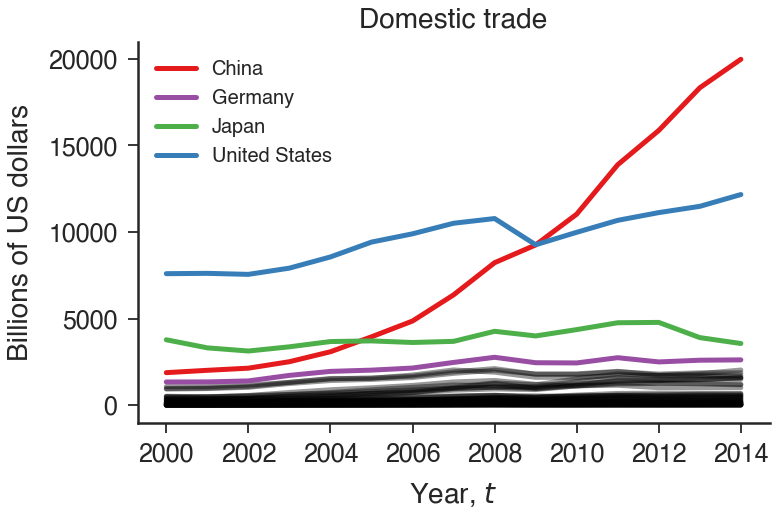

In [14]:
fig, ax = plt.subplots(figsize=(xs,ys))
colors={'China':'#e41a1c','United States':'#377eb8','Japan':'#4daf4a','Germany':'#984ea3'}
x=np.arange(2000,2015)
for i in range(0,len(countries)):
    country=countries.loc[i].Country
    y=(domestic_trade[i])/10**3
    if country in list(colors.keys()):
        ax.plot(x,y,label=country,color=colors[country],alpha=1,zorder=100)
    else:
        ax.plot(x,y,color='k',alpha=0.4)
    
ax.legend(loc="upper left",fontsize=20,frameon=False)
ax.set_title('Domestic trade')
ax.set_ylabel(r"Billions of US dollars",multialignment='center')
ax.set_xlabel(r"Year, $t$")
custom_frame(ax)
plt.savefig("../figures/domestic_trade.pdf",bbox_inches='tight')

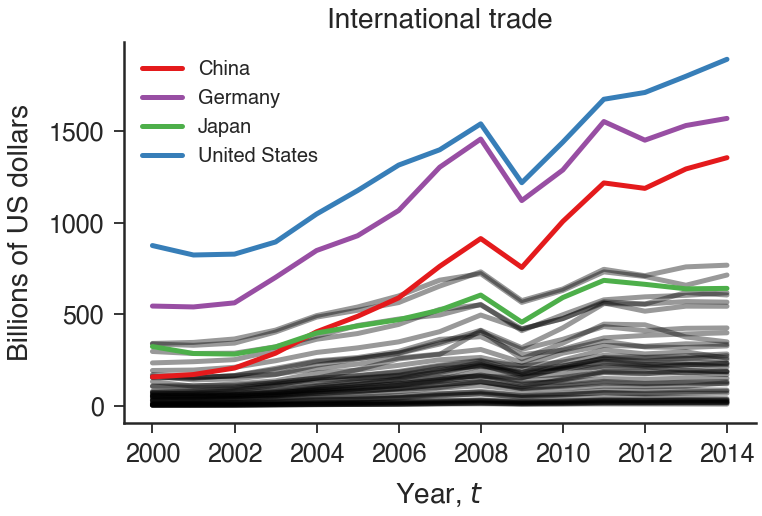

In [15]:
fig, ax = plt.subplots(figsize=(xs,ys))
colors={'China':'#e41a1c','United States':'#377eb8','Japan':'#4daf4a','Germany':'#984ea3'}
x=np.arange(2000,2015)
for i in range(0,len(countries)):
    country=countries.loc[i].Country
    y=(intenational_importers[i]+intenational_exporters[i])/10**3
    if country in list(colors.keys()):
        ax.plot(x,y,label=country,color=colors[country],alpha=1,zorder=100)
    else:
        ax.plot(x,y,color='k',alpha=0.4)
    
ax.legend(loc="upper left",fontsize=20,frameon=False)
ax.set_title('International trade')
ax.set_ylabel(r"Billions of US dollars",multialignment='center')
ax.set_xlabel(r"Year, $t$")
custom_frame(ax)
plt.savefig("../figures/international_trade.pdf",bbox_inches='tight')

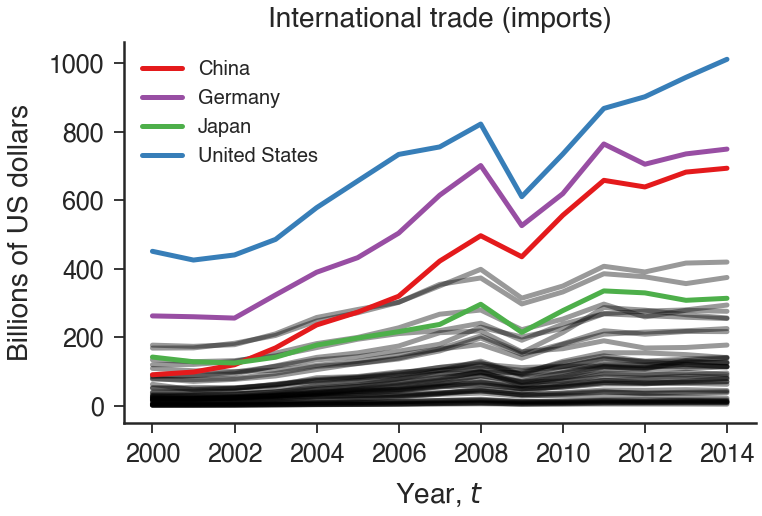

In [16]:
fig, ax = plt.subplots(figsize=(xs,ys))
colors={'China':'#e41a1c','United States':'#377eb8','Japan':'#4daf4a','Germany':'#984ea3'}
x=np.arange(2000,2015)
for i in range(0,len(countries)):
    country=countries.loc[i].Country
    y=(intenational_importers[i])/10**3
    if country in list(colors.keys()):
        ax.plot(x,y,label=country,color=colors[country],alpha=1,zorder=100)
    else:
        ax.plot(x,y,color='k',alpha=0.4)
    
ax.legend(loc="upper left",fontsize=20,frameon=False)
ax.set_title('International trade (imports)')
ax.set_ylabel(r"Billions of US dollars",multialignment='center')
ax.set_xlabel(r"Year, $t$")
custom_frame(ax)
plt.savefig("../figures/trade_importers.pdf",bbox_inches='tight')

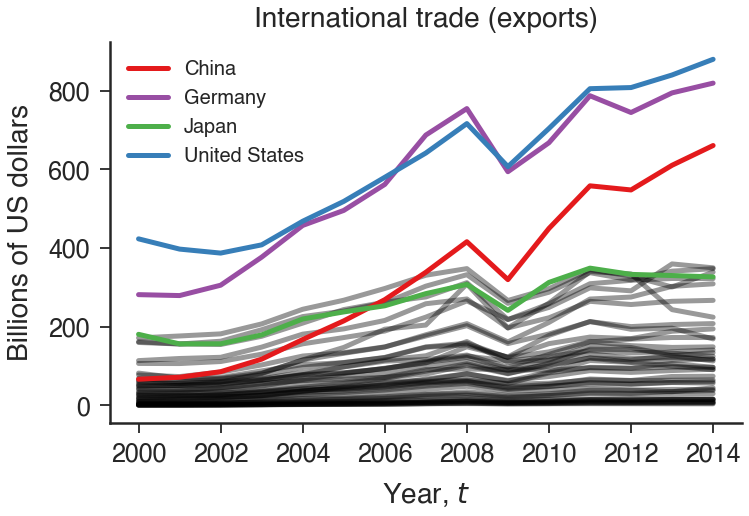

In [17]:
fig, ax = plt.subplots(figsize=(xs,ys))
colors={'China':'#e41a1c','United States':'#377eb8','Japan':'#4daf4a','Germany':'#984ea3'}
x=np.arange(2000,2015)
for i in range(0,len(countries)):
    country=countries.loc[i].Country
    y=(intenational_exporters[i])/10**3
    if country in list(colors.keys()):
        ax.plot(x,y,label=country,color=colors[country],alpha=1,zorder=100)
    else:
        ax.plot(x,y,color='k',alpha=0.4)
    
ax.legend(loc="upper left",fontsize=20,frameon=False)
ax.set_title('International trade (exports)')
ax.set_ylabel(r"Billions of US dollars",multialignment='center')
ax.set_xlabel(r"Year, $t$")
custom_frame(ax)
plt.savefig("../figures/trade_exporters.pdf",bbox_inches='tight')

# Multi-layer network:  Eigenvector centrality

- De Domenico, Manlio, et al. "Ranking in interconnected multilayer networks reveals versatile nodes." Nature communications 6 (2015): 6868.

In [18]:
labels=pd.read_csv("../data/sectors.csv",delimiter="\t",index_col=None)
labels.head()

Code                                           Activity
0        A01  Crop and animal production, hunting and relate...
1        A02                               Forestry and logging
2        A03                            Fishing and aquaculture
3          B                               Mining and quarrying
4  C10$-$C12  Manufacture of food products, beverages and to...

In [19]:
sectorsmap=dict()
for i in range(0,56):
    sectorsmap[i+1]=labels.loc[i].Code.replace('$','').replace('\\','')

## Sellers 

In [20]:
m=m_list[0].copy()
centrality=mnet_eigen_centrality(m,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43)
rank_centrality1=pd.DataFrame([centrality.keys(),centrality.values()],index=['Countries','buyers']).T

centrality=mnet_eigen_centrality(m.T,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43)
rank_centrality2=pd.DataFrame([centrality.keys(),centrality.values()],index=['Countries','sellers']).T

rank_centrality=pd.merge(rank_centrality1,rank_centrality2,on='Countries')
rank_centrality.sort_values('sellers',ascending=False).reset_index(drop=True)[:10]

Countries    buyers   sellers
0   United States  0.999887  0.999776
1           Japan  0.007006  0.015865
2          Canada  0.008682  0.011332
3          Mexico  0.007464  0.004656
4  United Kingdom   0.00299  0.003216
5         Germany  0.003261  0.003194
6  Korea Republic  0.002369   0.00254
7          France  0.001771  0.002213
8           China   0.00102  0.002125
9          Taiwan   0.00146  0.002013

In [21]:
rank_centrality.to_csv('../results/multilayer/rank_2000.csv')

## Buyers

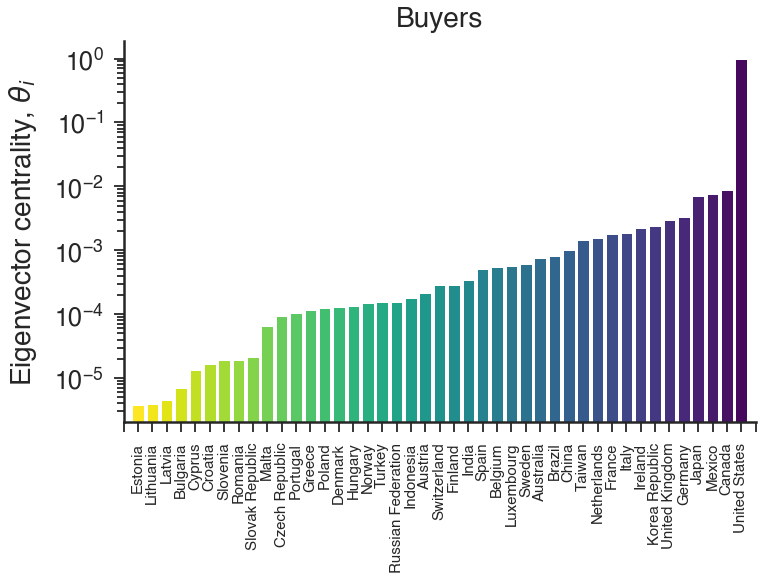

In [22]:
df=rank_centrality.sort_values('buyers')
y=df['buyers'].values.astype(float)
x=np.array([i for i in range(0,43)])
ax=eigenvector_plot(x,y,df)
ax.set_ylabel(r"Eigenvector centrality, $\theta _i$")
ax.set_title(r"Buyers")
ax.set_yscale('log')
custom_frame(ax)
plt.savefig("../figures/multilayer-eigenvector-buyers-2000.pdf",bbox_inches='tight')

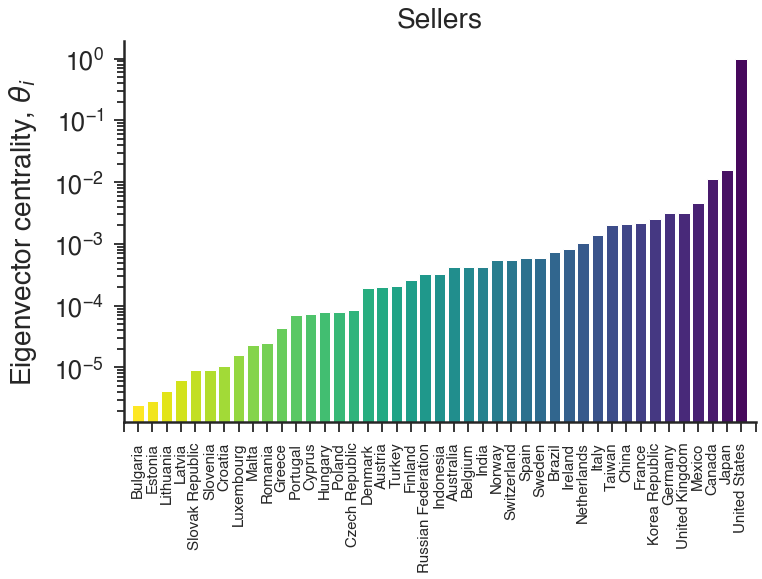

In [23]:
df=rank_centrality.sort_values('sellers')
y=df['sellers'].values.astype(float)
x=np.array([i for i in range(0,43)])
ax=eigenvector_plot(x,y,df)
ax.set_ylabel(r"Eigenvector centrality, $\theta _i$")
ax.set_title(r"Sellers")
ax.set_yscale('log')
# ax.set_title('Sellers')
custom_frame(ax)
plt.savefig("../figures/multilayer-eigenvector-sellers-2000.pdf",bbox_inches='tight')

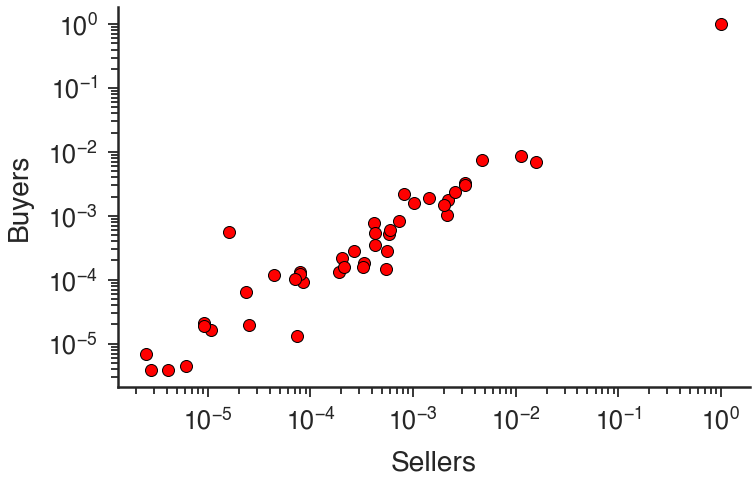

In [24]:
fig, ax = plt.subplots(figsize=(xs,ys))
ax.plot(rank_centrality.sellers,rank_centrality.buyers,
       color='r',
       marker='o',
       markersize=12,
       markeredgecolor='k',
       linewidth=0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"Buyers")
ax.set_xlabel(r"Sellers")
custom_frame(ax)

In [25]:
df1=rank_centrality.sort_values(by='buyers',ascending=False).reset_index(drop=True)
df1=df1[['Countries','buyers']]
df2=rank_centrality.sort_values(by='sellers',ascending=False).reset_index(drop=True)
df2=df2[['Countries','sellers']]
df_multilayer_kendall=pd.merge(df1,df2,on=['Countries'])
df_multilayer_kendall.head()

Countries    buyers   sellers
0  United States  0.999887  0.999776
1         Canada  0.008682  0.011332
2         Mexico  0.007464  0.004656
3          Japan  0.007006  0.015865
4        Germany  0.003261  0.003194

In [26]:
df_multilayer_kendall.to_csv('../results/multilayer/df_multilayer_kendall.csv')

In [27]:
df_multilayer_kendall=pd.read_csv('../results/multilayer/df_multilayer_kendall.csv',index_col=0)
df_multilayer_kendall=df_multilayer_kendall[['Countries','buyers','sellers']]
df_multilayer_kendall.head()

Countries    buyers   sellers
0  United States  0.999887  0.999776
1         Canada  0.008682  0.011332
2         Mexico  0.007464  0.004656
3          Japan  0.007006  0.015865
4        Germany  0.003261  0.003194

In [28]:
x=df_multilayer_kendall['buyers']
y=df_multilayer_kendall['sellers']
stats.kendalltau(x,y)[1]<10**(-14)

True

## Evolution of centrality

### Sellers

In [29]:
i=0
m=m_list[0].copy()
centrality=mnet_eigen_centrality(m.T,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43,max_iter=1000000)
multilayer_sellers=pd.DataFrame(pd.Series(centrality,index=centrality.keys()),columns=[2000+i])
multilayer_sellers=multilayer_sellers.reset_index().rename(columns={'index':'Countries'})
for i in range(1,len(m_list)):
    m=m_list[i].copy()
    centrality=mnet_eigen_centrality(m.T,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43,max_iter=1000000)
    eig_df2=pd.DataFrame(pd.Series(centrality,index=centrality.keys()),columns=[2000+i])
    eig_df2=eig_df2.reset_index().rename(columns={'index':'Countries'})
    multilayer_sellers=pd.merge(multilayer_sellers,eig_df2,on='Countries')

In [30]:
df_sellers_change=pd.DataFrame(np.transpose([multilayer_sellers[2008]-multilayer_sellers[2007],
                           multilayer_sellers['Countries']]),columns=['Change','Countries'])

df_sellers_change=df_sellers_change.sort_values(by='Change').reset_index(drop=True)

print(df_sellers_change.head(n=3))
print(df_sellers_change.tail(n=3))

     Change      Countries
0 -0.985908  United States
1 -0.012975         Canada
2 -0.005568         Mexico
      Change  Countries
40  0.009928  Australia
41  0.013667      Japan
42   0.95327      China


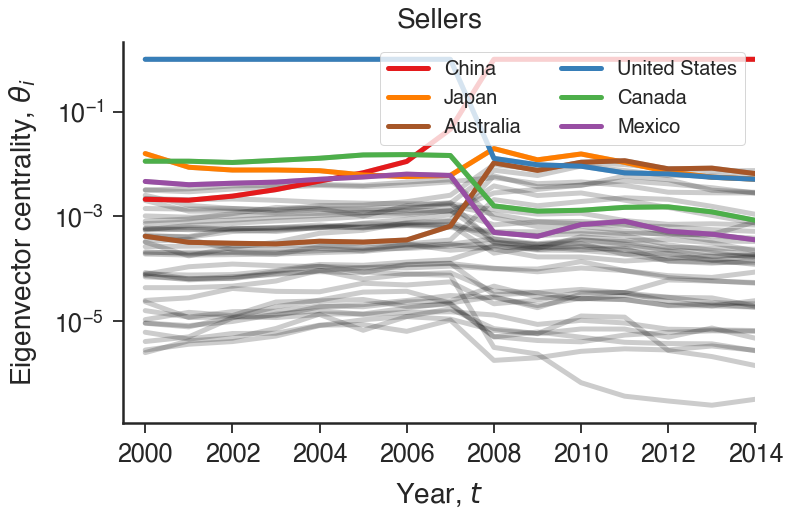

In [31]:
fig, ax = plt.subplots(figsize=(xs,ys))
colormap = plt.cm.viridis
colors=[colormap(i) for i in np.linspace(0, 0.9,len(list(multilayer_sellers.Countries)))]
for i,pais in enumerate(list(multilayer_sellers.Countries)):
    x,y=[int(i) for i in range(2000,2015)],(multilayer_sellers[multilayer_sellers.Countries==pais][[i for i in range(2000,2015)]].T.values)
    ax.plot(x,y,marker='o',
            color='k',#colors[i],
            markeredgecolor='k',
            markersize=0,
           linewidth=5,
           alpha=0.2)            
colors={'China':'#e41a1c',
        'Japan':'#ff7d00',
        'Australia':'#a65628',
        'United States':'#377eb8',
        'Canada':'#4daf4a',
        'Mexico':'#984ea3',
       }     

for country in list(colors.keys()):
        x,y=[i for i in range(2000,2015)],(multilayer_sellers[multilayer_sellers.Countries==country][[i for i in range(2000,2015)]].T.values)
        ax.plot(x,y,marker='o',
                color=colors[country],
                markeredgecolor='k',
                markersize=0,
               label=country,
               linewidth=5)
#ax.legend()
# ax.axvline(x=2008,color='#bdbdbd',linestyle='-',linewidth=30,zorder=-10)
ax.set_xlim(1999.5,2014)
ax.set_yscale('log')
ax.set_ylabel(r"Eigenvector centrality, $\theta _i$")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Sellers')
custom_frame(ax)
ax.legend(ncol=2)
plt.savefig("../figures/multilayer-sellers-log.pdf",bbox_inches='tight')

### Buyers 

In [32]:
i=0
m=m_list[0].copy()
centrality=mnet_eigen_centrality(m,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43,max_iter=1000000)
multilayer_buyers=pd.DataFrame(pd.Series(centrality,index=centrality.keys()),columns=[2000+i])
multilayer_buyers=multilayer_buyers.reset_index().rename(columns={'index':'Countries'})

for i in range(1,len(m_list)):
    m=m_list[i].copy()
    centrality=mnet_eigen_centrality(m,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43,max_iter=1000000)
    eig_df2=pd.DataFrame(pd.Series(centrality,index=centrality.keys()),columns=[2000+i])
    eig_df2=eig_df2.reset_index().rename(columns={'index':'Countries'})
    multilayer_buyers=pd.merge(multilayer_buyers,eig_df2,on='Countries')

In [33]:
df_buyers_change=pd.DataFrame(np.transpose([multilayer_buyers[2008]-multilayer_buyers[2007],
                           multilayer_buyers['Countries']]),columns=['Change','Countries'])

df_buyers_change=df_buyers_change.sort_values(by='Change').reset_index(drop=True)

print(df_buyers_change.head(n= 3))
print(df_buyers_change.tail(n= 3))

     Change      Countries
0  -0.95735  United States
1 -0.004446         Canada
2 -0.003212        Ireland
      Change       Countries
40   0.01151  Korea Republic
41  0.012844           Japan
42  0.984475           China


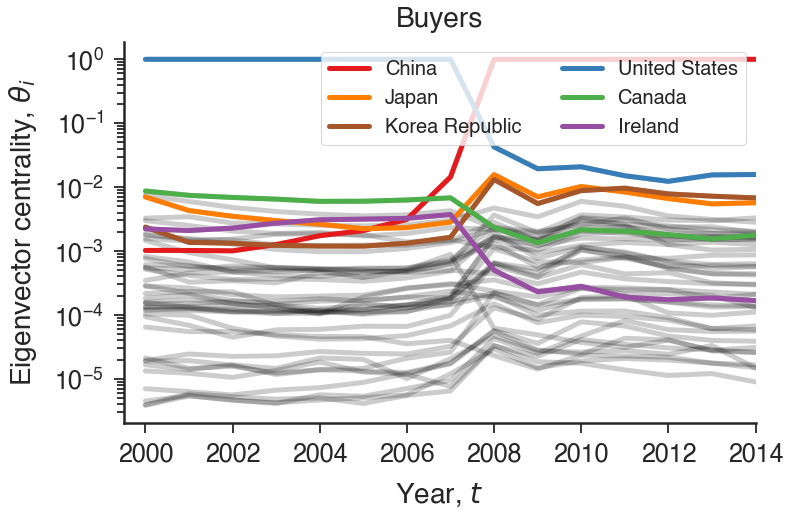

In [34]:
fig, ax = plt.subplots(figsize=(xs,ys))

colormap = plt.cm.viridis
colors=[colormap(i) for i in np.linspace(0, 0.9,len(list(multilayer_buyers.Countries)))]
for i,pais in enumerate(list(multilayer_buyers.Countries)):
    x,y=[int(i) for i in range(2000,2015)],(multilayer_buyers[multilayer_buyers.Countries==pais][[i for i in range(2000,2015)]].T.values)
    ax.plot(x,y,marker='o',
            color='k',#colors[i],
            markeredgecolor='k',
            markersize=0,
           linewidth=5,
           alpha=0.2)
# colors={'China':'#e41a1c','United States':'#377eb8','Canada':'#4daf4a','Japan':'#984ea3','Korea Republic':'#ff7d00','Cyprus':'k'}     
colors={'China':'#e41a1c',
        'Japan':'#ff7d00',
        'Korea Republic':'#a65628',
        'United States':'#377eb8',
        'Canada':'#4daf4a',
        'Ireland':'#984ea3'}     
for country in list(colors.keys()):
        x,y=[i for i in range(2000,2015)],(multilayer_buyers[multilayer_buyers.Countries==country][[i for i in range(2000,2015)]].T.values)
        ax.plot(x,y,marker='o',
                color=colors[country],
                markeredgecolor='k',
                markersize=0,
               label=country,
               linewidth=5)
ax.set_xlim(1999.5,2014)
ax.set_yscale('log')
ax.set_ylabel(r"Eigenvector centrality, $\theta_i$")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Buyers')
custom_frame(ax)
ax.legend(ncol=2)
plt.savefig("../figures/multilayer-buyers-log.pdf",bbox_inches='tight')

# SBM

In [35]:
key='buyer'

In [36]:
df_sellers=multilayer_sellers.set_index('Countries').T
df_sellers.head()

Countries  Australia   Austria   Belgium  Bulgaria    Brazil    Canada  \
2000        0.000418  0.000201  0.000427  0.000003  0.000730  0.011332   
2001        0.000321  0.000208  0.000413  0.000004  0.000780  0.011336   
2002        0.000308  0.000209  0.000597  0.000005  0.000850  0.010718   
2003        0.000299  0.000205  0.000582  0.000007  0.000956  0.011774   
2004        0.000337  0.000221  0.000609  0.000014  0.001046  0.012922   

Countries  Switzerland     China    Cyprus  Czech Republic  ...    Poland  \
2000          0.000556  0.002125  0.000075        0.000085  ...  0.000080   
2001          0.000673  0.002041  0.000062        0.000064  ...  0.000076   
2002          0.000739  0.002444  0.000066        0.000071  ...  0.000078   
2003          0.000821  0.003251  0.000089        0.000078  ...  0.000093   
2004          0.000886  0.004739  0.000113        0.000093  ...  0.000121   

Countries  Portugal   Romania  Russian Federation  Slovak Republic  Slovenia  \
2000       0.000070  0.000025            0.000324         0.000009  0.000009   
2001       0.000065  0.000028            0.000177         0.000008  0.000008   
2002       0.000065  0.000042            0.000256         0.000012  0.000010   
2003       0.000082  0.000037            0.000322         0.000013  0.000014   
2004       0.000088  0.000036            0.000477         0.000019  0.000016   

Countries    Sweden    Turkey    Taiwan  United States  
2000       0.000594  0.000212  0.002013       0.999776  
2001       0.000558  0.000194  0.001260       0.999870  
2002       0.000585  0.000204  0.001265       0.999880  
2003       0.000608  0.000190  0.001187       0.999863  
2004       0.000688  0.000266  0.001338       0.999839  

[5 rows x 43 columns]

In [37]:
df_buyers=multilayer_buyers.set_index('Countries').T
df_buyers.head()

Countries  Australia   Austria   Belgium  Bulgaria    Brazil    Canada  \
2000        0.000760  0.000217  0.000544  0.000007  0.000820  0.008682   
2001        0.000567  0.000232  0.000511  0.000006  0.000672  0.007423   
2002        0.000531  0.000229  0.000583  0.000006  0.000468  0.006877   
2003        0.000556  0.000143  0.000545  0.000007  0.000416  0.006475   
2004        0.000528  0.000126  0.000518  0.000007  0.000395  0.005974   

Countries  Switzerland     China    Cyprus  Czech Republic  ...    Poland  \
2000          0.000284  0.001020  0.000013        0.000094  ...  0.000123   
2001          0.000263  0.001019  0.000012        0.000069  ...  0.000117   
2002          0.000207  0.001005  0.000011        0.000045  ...  0.000111   
2003          0.000191  0.001261  0.000014        0.000058  ...  0.000105   
2004          0.000197  0.001732  0.000018        0.000059  ...  0.000120   

Countries  Portugal   Romania  Russian Federation  Slovak Republic  Slovenia  \
2000       0.000104  0.000019            0.000157         0.000021  0.000019   
2001       0.000099  0.000024            0.000173         0.000015  0.000019   
2002       0.000062  0.000022            0.000152         0.000016  0.000016   
2003       0.000047  0.000023            0.000124         0.000012  0.000012   
2004       0.000042  0.000027            0.000107         0.000014  0.000014   

Countries    Sweden    Turkey    Taiwan  United States  
2000       0.000608  0.000156  0.001460       0.999887  
2001       0.000594  0.000132  0.000944       0.999928  
2002       0.000492  0.000112  0.000727       0.999945  
2003       0.000509  0.000116  0.000542       0.999951  
2004       0.000489  0.000109  0.000522       0.999956  

[5 rows x 43 columns]

In [38]:
def pd_clustering_distances(ts,index,metric='correlation'):
    corr_dis = pd.DataFrame(squareform(np.sqrt(2*pdist(ts.T.values,metric=metric))),
                        columns=index, index=index)
    return corr_dis


In [39]:
# conda install -c conda-forge graph-tool

In [40]:
import graph_tool.all as gt

## Buyers 

In [41]:
df_sellers.head()

Countries  Australia   Austria   Belgium  Bulgaria    Brazil    Canada  \
2000        0.000418  0.000201  0.000427  0.000003  0.000730  0.011332   
2001        0.000321  0.000208  0.000413  0.000004  0.000780  0.011336   
2002        0.000308  0.000209  0.000597  0.000005  0.000850  0.010718   
2003        0.000299  0.000205  0.000582  0.000007  0.000956  0.011774   
2004        0.000337  0.000221  0.000609  0.000014  0.001046  0.012922   

Countries  Switzerland     China    Cyprus  Czech Republic  ...    Poland  \
2000          0.000556  0.002125  0.000075        0.000085  ...  0.000080   
2001          0.000673  0.002041  0.000062        0.000064  ...  0.000076   
2002          0.000739  0.002444  0.000066        0.000071  ...  0.000078   
2003          0.000821  0.003251  0.000089        0.000078  ...  0.000093   
2004          0.000886  0.004739  0.000113        0.000093  ...  0.000121   

Countries  Portugal   Romania  Russian Federation  Slovak Republic  Slovenia  \
2000       0.000070  0.000025            0.000324         0.000009  0.000009   
2001       0.000065  0.000028            0.000177         0.000008  0.000008   
2002       0.000065  0.000042            0.000256         0.000012  0.000010   
2003       0.000082  0.000037            0.000322         0.000013  0.000014   
2004       0.000088  0.000036            0.000477         0.000019  0.000016   

Countries    Sweden    Turkey    Taiwan  United States  
2000       0.000594  0.000212  0.002013       0.999776  
2001       0.000558  0.000194  0.001260       0.999870  
2002       0.000585  0.000204  0.001265       0.999880  
2003       0.000608  0.000190  0.001187       0.999863  
2004       0.000688  0.000266  0.001338       0.999839  

[5 rows x 43 columns]

In [42]:
label=['seller','buyer']
g=dict()
for i,dataframe in enumerate([df_sellers,df_buyers]):
    distances=pd_clustering_distances(dataframe,dataframe.columns,metric='correlation')

    edgetuplelist=[]
    weights=[]
    for k,nodek in enumerate(distances.columns):
        for j,nodej in enumerate(distances.index):
            if k<j:
                edgetuplelist.append((nodek,nodej))
                weights.append(distances[nodek].loc[nodej])
    g[label[i]] = gt.Graph(directed=False)
    gmap = g[label[i]].add_edge_list(edgetuplelist,  hashed=True)
    g[label[i]].edge_properties['weight'] =g[label[i]].new_edge_property("double",
                                                     vals=np.array(weights))

    g[label[i]].vertex_properties["name"]=g[label[i]].new_vertex_property(
        "string",vals=[gmap[ind_] for ind_ in g[label[i]].vertex_index])
    g[label[i]].vertex_properties['degree']=g[label[i]].new_vertex_property(
        "double",vals=g[label[i]].get_in_degrees(list(g[label[i]].vertex_index))) 

In [43]:
state = gt.minimize_nested_blockmodel_dl(g[key], state_args=dict(recs=[g[key].ep.weight],
                                                            rec_types=["real-normal"],
                                                                 deg_corr=True)
                                         )
print('Nested DCSBM: ',state.entropy())

state = gt.minimize_nested_blockmodel_dl(g[key], state_args=dict(recs=[g[key].ep.weight],
                                                            rec_types=["real-normal"],
                                                                 deg_corr=False)
                                         )
print('Nested SBM: ',state.entropy())

state = gt.minimize_blockmodel_dl(g[key], state_args=dict(recs=[g[key].ep.weight],
                                                            rec_types=["real-normal"],
                                                            deg_corr=True)
                                  )
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))
print('DCSBM: ',state.entropy())

state = gt.minimize_blockmodel_dl(g[key], state_args=dict(recs=[g[key].ep.weight],
                                                            rec_types=["real-normal"],
                                                         deg_corr=False)
                                     )
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))
print('SBM: ',state.entropy())

Nested DCSBM:  569.3675399292827
Nested SBM:  550.6128826693131
DCSBM:  446.5608657527345
SBM:  426.9510559358504


In [44]:
state_buyers = gt.NestedBlockState(g[key],
                            state_args=dict(recs=[g[key].ep.weight],rec_types=["real-normal"], deg_corr=False),
                           )  

# Now we run 10000 sweeps of the MCMC

dS, nmoves = 0, 0
for i in range(100):
    ret = state_buyers.multiflip_mcmc_sweep(niter=10)
    dS += ret[0]
    nmoves += ret[1]

print("Change in description length:", dS)
print("Number of accepted vertex moves:", nmoves)

# We will first equilibrate the Markov chain
gt.mcmc_equilibrate(state_buyers, wait=100, mcmc_args=dict(niter=10))

# collect nested partitions
bs = []

def collect_partitions(s):
    global bs
    bs.append(s.get_bs())

# Now we collect the marginals for exactly 100,000 sweeps
gt.mcmc_equilibrate(state_buyers, force_niter=100, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

# Disambiguate partitions and obtain marginals
pmode = gt.PartitionModeState(bs, nested=True, converge=True)
pv_buyers = pmode.get_marginal(g[key])

# Get consensus estimate
bs = pmode.get_max_nested()

state_buyers = state_buyers.copy(bs=bs)

Change in description length: -1098.2555620490248
Number of accepted vertex moves: 223920


In [45]:
v_marginal_buyers=np.array([np.array(b) for b in bs])

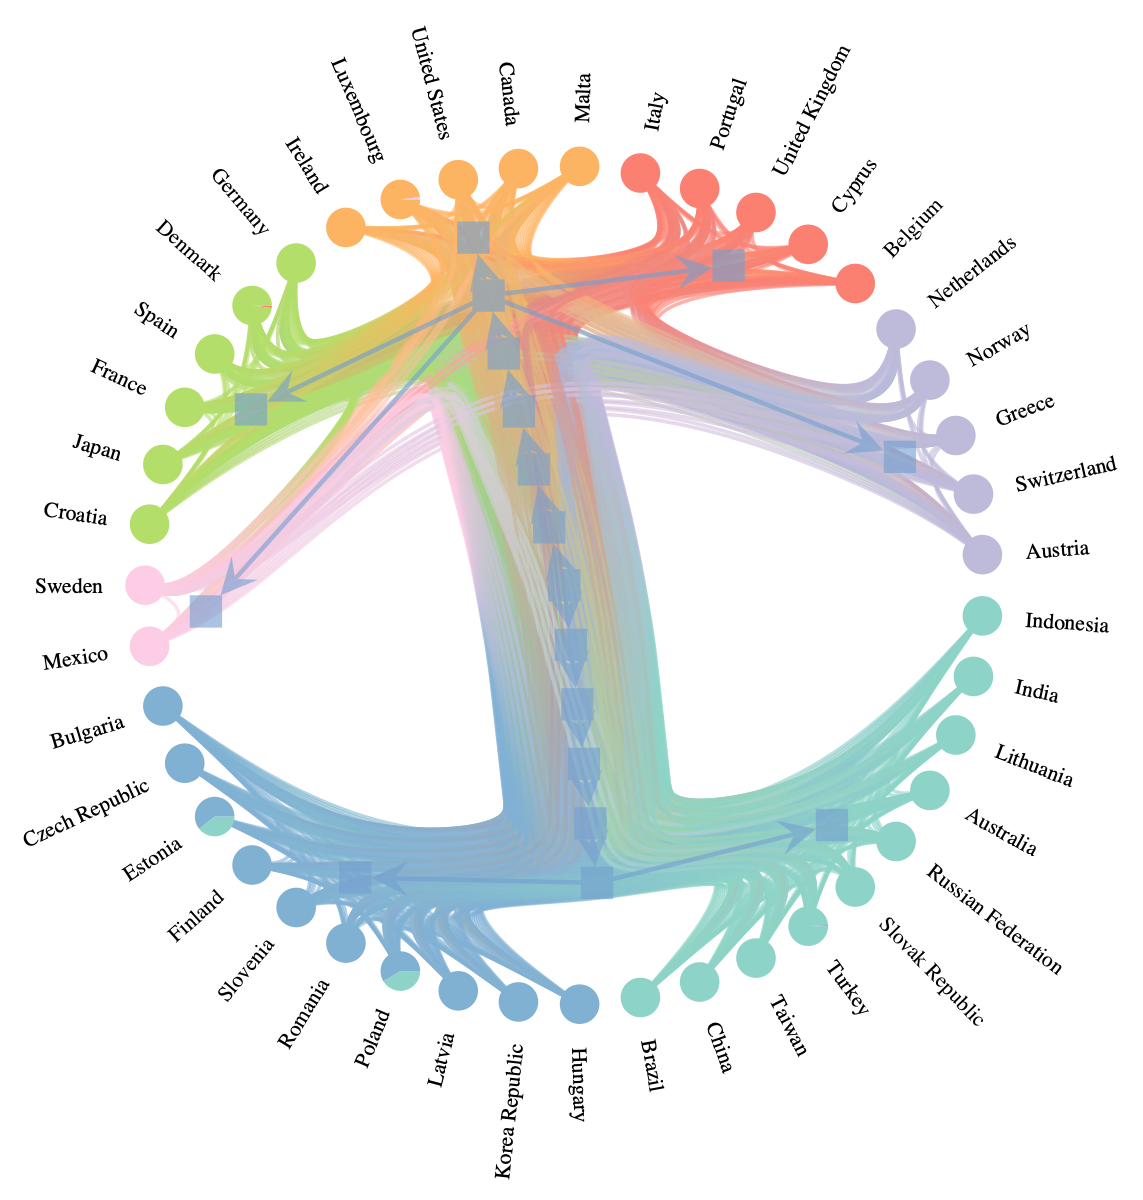

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8438e48f70, at 0x7f8428d42460>,
 <Graph object, directed, with 61 vertices and 60 edges, at 0x7f8438cdc6a0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8438cdc6a0, at 0x7f8438cdc580>)

In [46]:
# We can visualize the marginals as pie charts on the nodes:
state_buyers.draw(vertex_shape="pie", 
           vertex_text_position="centered",
           output_size=(600, 600),
           vertex_pie_fractions=pv_buyers,
           vertex_size=18, 
           vertex_text=g['buyer'].vertex_properties["name"],
#            vertex_text_size=30,
#            output='../figures/sellers_nested_sbm.svg'
          )

## Sellers

In [47]:
key='seller'

In [48]:
state = gt.minimize_nested_blockmodel_dl(g[key], state_args=dict(recs=[g[key].ep.weight],
                                                            rec_types=["real-normal"],
                                                                 deg_corr=True)
                                         )
print('Nested DCSBM: ',state.entropy())

state = gt.minimize_nested_blockmodel_dl(g[key], state_args=dict(recs=[g[key].ep.weight],
                                                            rec_types=["real-normal"],
                                                                 deg_corr=False)
                                         )
print('Nested SBM: ',state.entropy())

state = gt.minimize_blockmodel_dl(g[key], state_args=dict(recs=[g[key].ep.weight],
                                                            rec_types=["real-normal"],
                                                            deg_corr=True)
                                  )
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))
print('DCSBM: ',state.entropy())

state = gt.minimize_blockmodel_dl(g[key], state_args=dict(recs=[g[key].ep.weight],
                                                            rec_types=["real-normal"],
                                                         deg_corr=False)
                                     )
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))
print('SBM: ',state.entropy())

Nested DCSBM:  599.2067337360672
Nested SBM:  562.8722136936356
DCSBM:  448.28255276706466
SBM:  422.00210769289134


In [49]:
state = gt.minimize_nested_blockmodel_dl(g[key], state_args=dict(recs=[g[key].ep.weight],
                                                            rec_types=["real-normal"],deg_corr=False)
                                     )

In [50]:
state_sellers = gt.NestedBlockState(g[key],
                            state_args=dict(recs=[g[key].ep.weight],rec_types=["real-normal"],deg_corr=False),
                            )  

# Now we run 10000 sweeps of the MCMC

dS, nmoves = 0, 0
for i in range(100):
    ret = state_sellers.multiflip_mcmc_sweep(niter=10)
    dS += ret[0]
    nmoves += ret[1]

print("Change in description length:", dS)
print("Number of accepted vertex moves:", nmoves)

# We will first equilibrate the Markov chain
gt.mcmc_equilibrate(state_sellers, wait=100, mcmc_args=dict(niter=10))

# collect nested partitions
bs = []

def collect_partitions(s):
    global bs
    bs.append(s.get_bs())

# Now we collect the marginals for exactly 100,000 sweeps
gt.mcmc_equilibrate(state_sellers, force_niter=100, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

# Disambiguate partitions and obtain marginals
pmode = gt.PartitionModeState(bs, nested=True, converge=True)
pv_sellers = pmode.get_marginal(g[key])

# Get consensus estimate
bs = pmode.get_max_nested()

state_sellers = state_sellers.copy(bs=bs)

Change in description length: -1070.3711410301587
Number of accepted vertex moves: 266602


In [51]:
v_marginal_sellers=np.array([np.array(b) for b in bs])

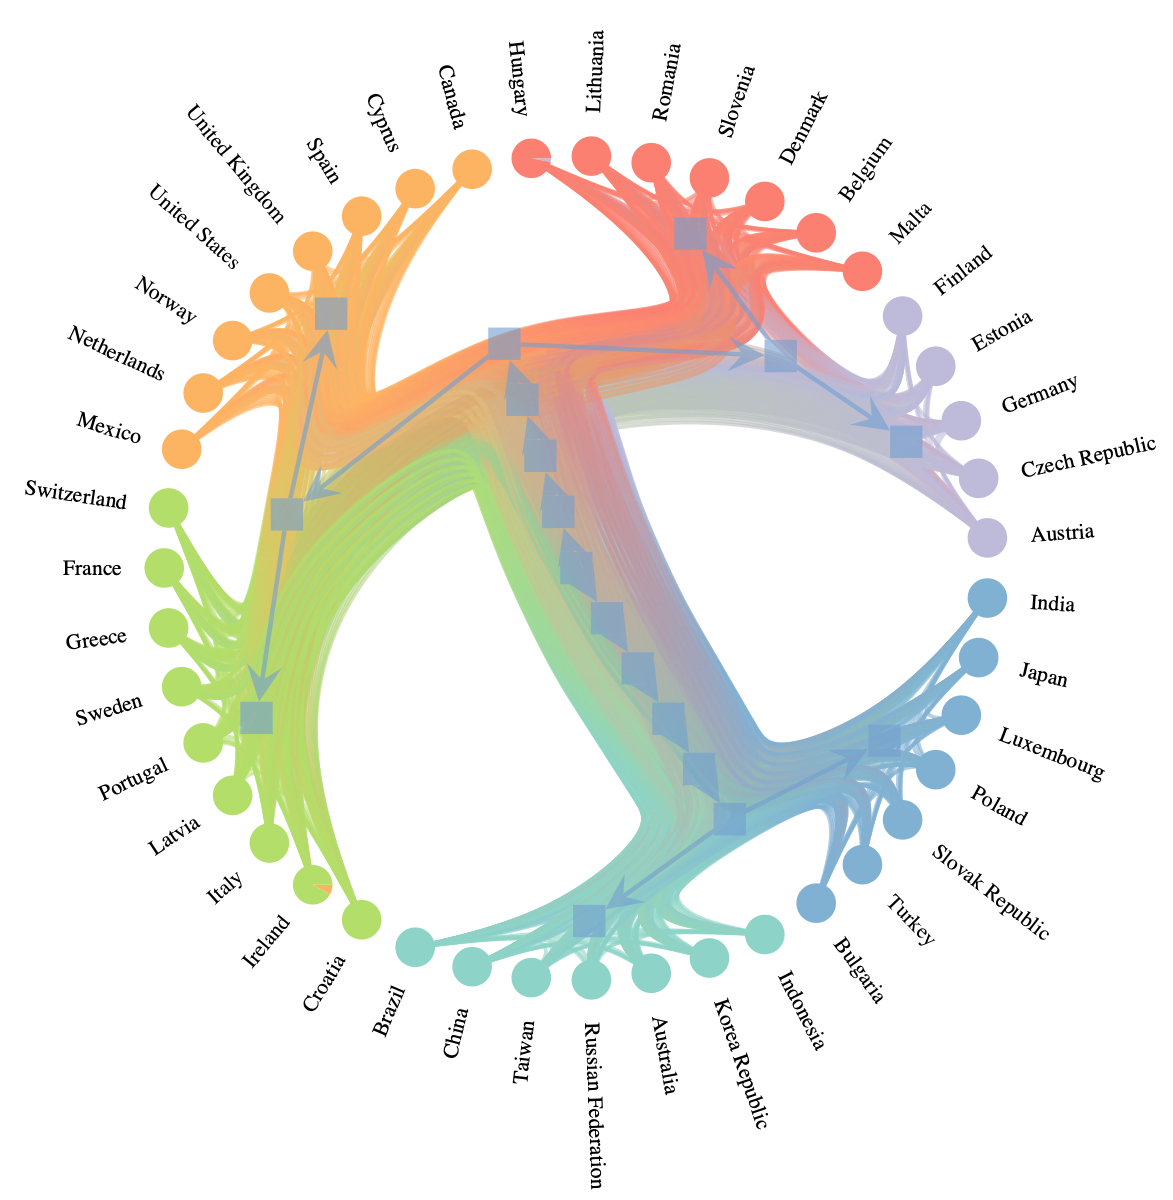

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f844adcf910, at 0x7f8438cf6370>,
 <Graph object, directed, with 61 vertices and 60 edges, at 0x7f844b0fe850>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f844b0fe850, at 0x7f844b082400>)

In [52]:
# We can visualize the marginals as pie charts on the nodes:
state_sellers.draw(vertex_shape="pie", 
           vertex_text_position="centered",
           output_size=(600, 600),
           vertex_pie_fractions=pv_sellers,
           vertex_size=18, 
           vertex_text=g['seller'].vertex_properties["name"],
#            vertex_text_size=30,
#            output='../figures/sellers_nested_sbm.svg'
          )

# Clustering analysis

In [53]:
df_sellers=multilayer_sellers.set_index('Countries').T
df_sellers.head()

Countries  Australia   Austria   Belgium  Bulgaria    Brazil    Canada  \
2000        0.000418  0.000201  0.000427  0.000003  0.000730  0.011332   
2001        0.000321  0.000208  0.000413  0.000004  0.000780  0.011336   
2002        0.000308  0.000209  0.000597  0.000005  0.000850  0.010718   
2003        0.000299  0.000205  0.000582  0.000007  0.000956  0.011774   
2004        0.000337  0.000221  0.000609  0.000014  0.001046  0.012922   

Countries  Switzerland     China    Cyprus  Czech Republic  ...    Poland  \
2000          0.000556  0.002125  0.000075        0.000085  ...  0.000080   
2001          0.000673  0.002041  0.000062        0.000064  ...  0.000076   
2002          0.000739  0.002444  0.000066        0.000071  ...  0.000078   
2003          0.000821  0.003251  0.000089        0.000078  ...  0.000093   
2004          0.000886  0.004739  0.000113        0.000093  ...  0.000121   

Countries  Portugal   Romania  Russian Federation  Slovak Republic  Slovenia  \
2000       0.000070  0.000025            0.000324         0.000009  0.000009   
2001       0.000065  0.000028            0.000177         0.000008  0.000008   
2002       0.000065  0.000042            0.000256         0.000012  0.000010   
2003       0.000082  0.000037            0.000322         0.000013  0.000014   
2004       0.000088  0.000036            0.000477         0.000019  0.000016   

Countries    Sweden    Turkey    Taiwan  United States  
2000       0.000594  0.000212  0.002013       0.999776  
2001       0.000558  0.000194  0.001260       0.999870  
2002       0.000585  0.000204  0.001265       0.999880  
2003       0.000608  0.000190  0.001187       0.999863  
2004       0.000688  0.000266  0.001338       0.999839  

[5 rows x 43 columns]

In [54]:
df_buyers=multilayer_buyers.set_index('Countries').T
df_buyers.head()

Countries  Australia   Austria   Belgium  Bulgaria    Brazil    Canada  \
2000        0.000760  0.000217  0.000544  0.000007  0.000820  0.008682   
2001        0.000567  0.000232  0.000511  0.000006  0.000672  0.007423   
2002        0.000531  0.000229  0.000583  0.000006  0.000468  0.006877   
2003        0.000556  0.000143  0.000545  0.000007  0.000416  0.006475   
2004        0.000528  0.000126  0.000518  0.000007  0.000395  0.005974   

Countries  Switzerland     China    Cyprus  Czech Republic  ...    Poland  \
2000          0.000284  0.001020  0.000013        0.000094  ...  0.000123   
2001          0.000263  0.001019  0.000012        0.000069  ...  0.000117   
2002          0.000207  0.001005  0.000011        0.000045  ...  0.000111   
2003          0.000191  0.001261  0.000014        0.000058  ...  0.000105   
2004          0.000197  0.001732  0.000018        0.000059  ...  0.000120   

Countries  Portugal   Romania  Russian Federation  Slovak Republic  Slovenia  \
2000       0.000104  0.000019            0.000157         0.000021  0.000019   
2001       0.000099  0.000024            0.000173         0.000015  0.000019   
2002       0.000062  0.000022            0.000152         0.000016  0.000016   
2003       0.000047  0.000023            0.000124         0.000012  0.000012   
2004       0.000042  0.000027            0.000107         0.000014  0.000014   

Countries    Sweden    Turkey    Taiwan  United States  
2000       0.000608  0.000156  0.001460       0.999887  
2001       0.000594  0.000132  0.000944       0.999928  
2002       0.000492  0.000112  0.000727       0.999945  
2003       0.000509  0.000116  0.000542       0.999951  
2004       0.000489  0.000109  0.000522       0.999956  

[5 rows x 43 columns]

In [55]:
def pd_clustering_distances(ts,index,metric='correlation'):
    corr_dis = pd.DataFrame(squareform(np.sqrt(2*pdist(ts.T.values,metric=metric))),
                        columns=index, index=index)
    return corr_dis

def compute_silhouettes(d,lc):
    """
    d - distance list
    lc - linkage 
    """
    d_thresholds= np.linspace(min(squareform(d)),max(squareform(d)),num=100)
    silhouettes = [silhouette_score(d,scipy.cluster.hierarchy.fcluster(lc,dt, 'distance'),
                   metric='precomputed') for dt in d_thresholds]
    return d_thresholds,silhouettes

def best_clustering(d,lc,d_thresholds,silhouettes):
    firt_local_max_silhouettes = np.argmax(np.diff(silhouettes)<0)
    global_max_silhouettes = np.argmax(silhouettes)

    best_clustering_labels = scipy.cluster.hierarchy.fcluster(lc,
                                                              d_thresholds[global_max_silhouettes], 
                                                             'distance')
    return firt_local_max_silhouettes,global_max_silhouettes,best_clustering_labels

In [56]:
countrymap=dict()
for i in range(1,44):
    countrymap[i]=countries.loc[i-1].Country
    
sectormap=dict()
for i in range(1,56):
    sectormap[i]=sectors.loc[i-1].Activity

## Buyers 

### Dendrogram 

In [57]:
distances=pd_clustering_distances(df_buyers,df_buyers.columns,metric='correlation')
linkage = scipy.cluster.hierarchy.linkage(squareform(distances), method='ward')
d_thresholds,silhouettes=compute_silhouettes(distances,linkage)
firt_local_max_silhouettes,global_max_silhouettes,best_clustering_labels=best_clustering(distances,
                                                                                         linkage,
                                                                                         d_thresholds,
                                                                                         silhouettes)

color_for =  palettable.tableau.GreenOrange_6.hex_colors+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]

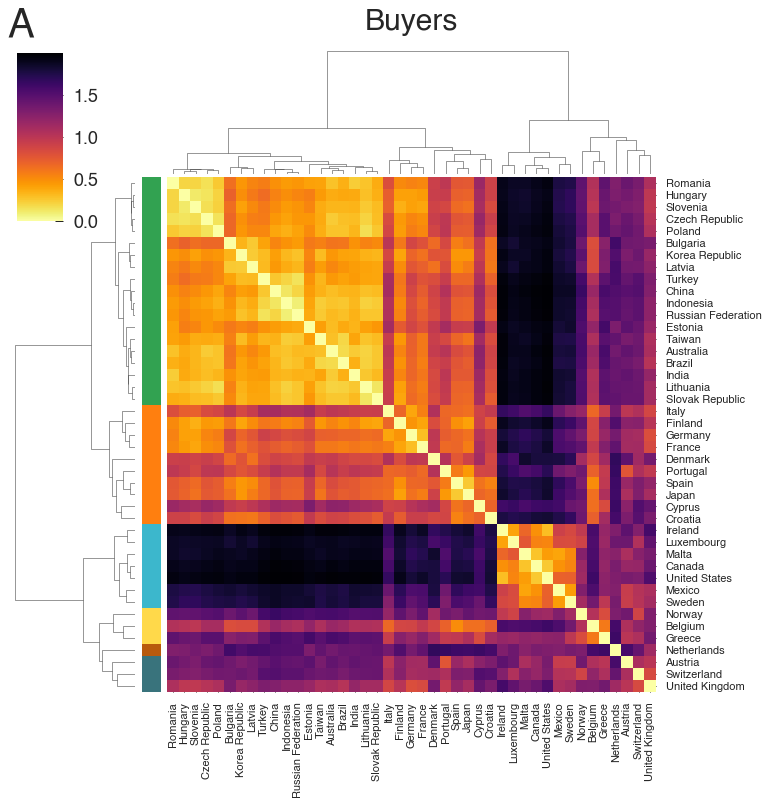

In [58]:
f = sns.clustermap(distances,
                   figsize=(13, 13),
                   linewidths=.0,
                   linecolor='w',
                   yticklabels=True,
                   xticklabels=True,
                   cmap='inferno_r',
                   col_linkage=linkage,
                   row_linkage=linkage,
#                    row_cluster=False,
#                    col_cluster=False,
                   row_colors=color_for_ordered, 
#                    cbar_pos=(-0.08, 0.75, .03, .2)
                  )

f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xticklabels(),fontsize=11);
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_yticklabels(),fontsize=11);
# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xticklabels(),fontsize=11);
# f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_yticklabels(),fontsize=11);
f.ax_heatmap.tick_params(width=1, length=5)
f.ax_heatmap.collections[0].colorbar.ax.tick_params(labelsize=18, width=1, length=8)
plt.setp(f.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.annotate('A', xy=(-0.2, 1.1), xycoords="axes fraction",fontsize=40,fontweight="bold")
f.ax_col_dendrogram.set_title('Buyers',fontsize=30)
f.ax_heatmap.set_xlabel('');
f.ax_heatmap.set_ylabel('');
f.savefig('../figures/buyers-dendrogram.pdf')

In [59]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Parameters
    ----------
    color: the color variable (e.g. 'g', '#F034A3', (.3,.55,.1)).
    amount: the lighten amount factor (Default: 0.5)
    ----------
    returns modified color
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return mpl.colors.to_hex(colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2]))
    

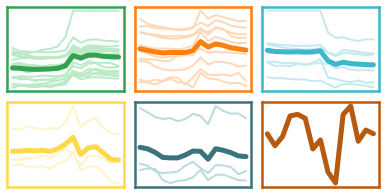

In [60]:
df_ts=df_buyers.T
df_ts['groups']=best_clustering_labels

color =  palettable.tableau.GreenOrange_6.hex_colors
f, axs = plt.subplots(nrows=2, ncols=3, figsize=stdfigsize(nx=3, ny=2, scale=0.2))

for i in range(1,len(np.unique(best_clustering_labels))+1):
    ax=axs.flatten()[i-1]
    df_group=df_ts[df_ts.groups==i][[year for year in range(2000,2015)]].T
    df_group=df_group.apply(np.log)
    df_group.plot(legend=False,ax=ax,color=lighten_color(color[i-1], amount=0.3),alpha=1,lw=2)
    df_group.mean(axis=1).plot(color=color[i-1],alpha=1,ax=ax)
    # ax.set_yscale('log')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    ax.spines['top'].set_color(color[i-1])
    ax.spines['right'].set_color(color[i-1])
    ax.spines['bottom'].set_color(color[i-1])
    ax.spines['left'].set_color(color[i-1])
    
    
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
# for ax in axs.flatten()[5:]:
#     f.delaxes(ax)
f.tight_layout() 
f.savefig('../figures/avg_centrality_buyers.pdf')

In [61]:
best_clustering_labels_buyers=best_clustering_labels

In [62]:
normalized_mutual_info_score(best_clustering_labels_buyers,v_marginal_buyers[0])

0.6942111559796513

### Within-block null model comparison

In [63]:
def randomize_links(df,direction='source_node'):
    df_rand=df.copy()
    for i in range(0, len(df_rand)):
        n1=np.random.choice(df_rand.index)
        n2=np.random.choice(df_rand.index)

        while (n1==n2 and df_rand.loc[n1][direction]==df_rand.loc[n2][direction]):
            n1=np.random.choice(df_rand.index)
            n2=np.random.choice(df_rand.index)

        country1,country2=df_rand.loc[n1][direction],df_rand.loc[n2][direction]
        df_rand.at[n1,direction]=country2
        df_rand.at[n2,direction]=country1
    return df_rand

In [64]:
def randomize_weights_globally(df):
    df_rand=df.copy()
    weight=df_rand['weight'].values
    np.random.shuffle(weight)
    df_rand['weight']=weight
    return df_rand

In [65]:
def randomize_weights_locally(df,direction='source_node'):
    df_rand=df.copy()
    for k in np.unique(df[direction]):
        wij=df_rand[df_rand[direction]==k].weight.values
        indices=df_rand[df_rand[direction]==k].index
        np.random.shuffle(wij)
        for w,ind in enumerate(indices):
            df_rand.at[ind,'weight']=wij[w]
    return df_rand

In [66]:
buyers_results=[]
for group in np.unique(best_clustering_labels):
    group_results=[]
    real_values=[]
    for year in range(0,15):
        df=edge_dfbyyear[year].copy()
        df=df[df['source_node']!=df['destination_node']]
        df=df.groupby(['source_node','destination_node']).sum()
        df=df.reset_index()[['source_node','destination_node','weight']]
        df['source_node']=df['source_node'].map(countrymap)
        df['destination_node']=df['destination_node'].map(countrymap)
        
        sub_df_real=df[df['destination_node'].isin(df_buyers.columns[best_clustering_labels==group])]
        within_fraction=sub_df_real[sub_df_real['source_node'].isin(df_buyers.columns[best_clustering_labels==group])]

        randvalue=[]
        for i in range(0,30):
            #df_rand=randomize_links(df,'source_node')
            #df_rand=randomize_weights_globally(df)
            df_rand=randomize_weights_locally(df,direction='destination_node')
            
            sub_df=df_rand[df_rand['destination_node'].isin(df_buyers.columns[best_clustering_labels==group])]
            within_fraction_rand=sub_df[sub_df['source_node'].isin(df_buyers.columns[best_clustering_labels==group])]
            randvalue.append(within_fraction_rand['weight'].sum()/sub_df['weight'].sum())
        real_values.append(within_fraction['weight'].sum()/sub_df_real['weight'].sum())
        group_results.append(randvalue)
    buyers_results.append([real_values,group_results])


In [67]:
stdfigsize(nx=1, ny=1, scale=1)

(9.1, 7)

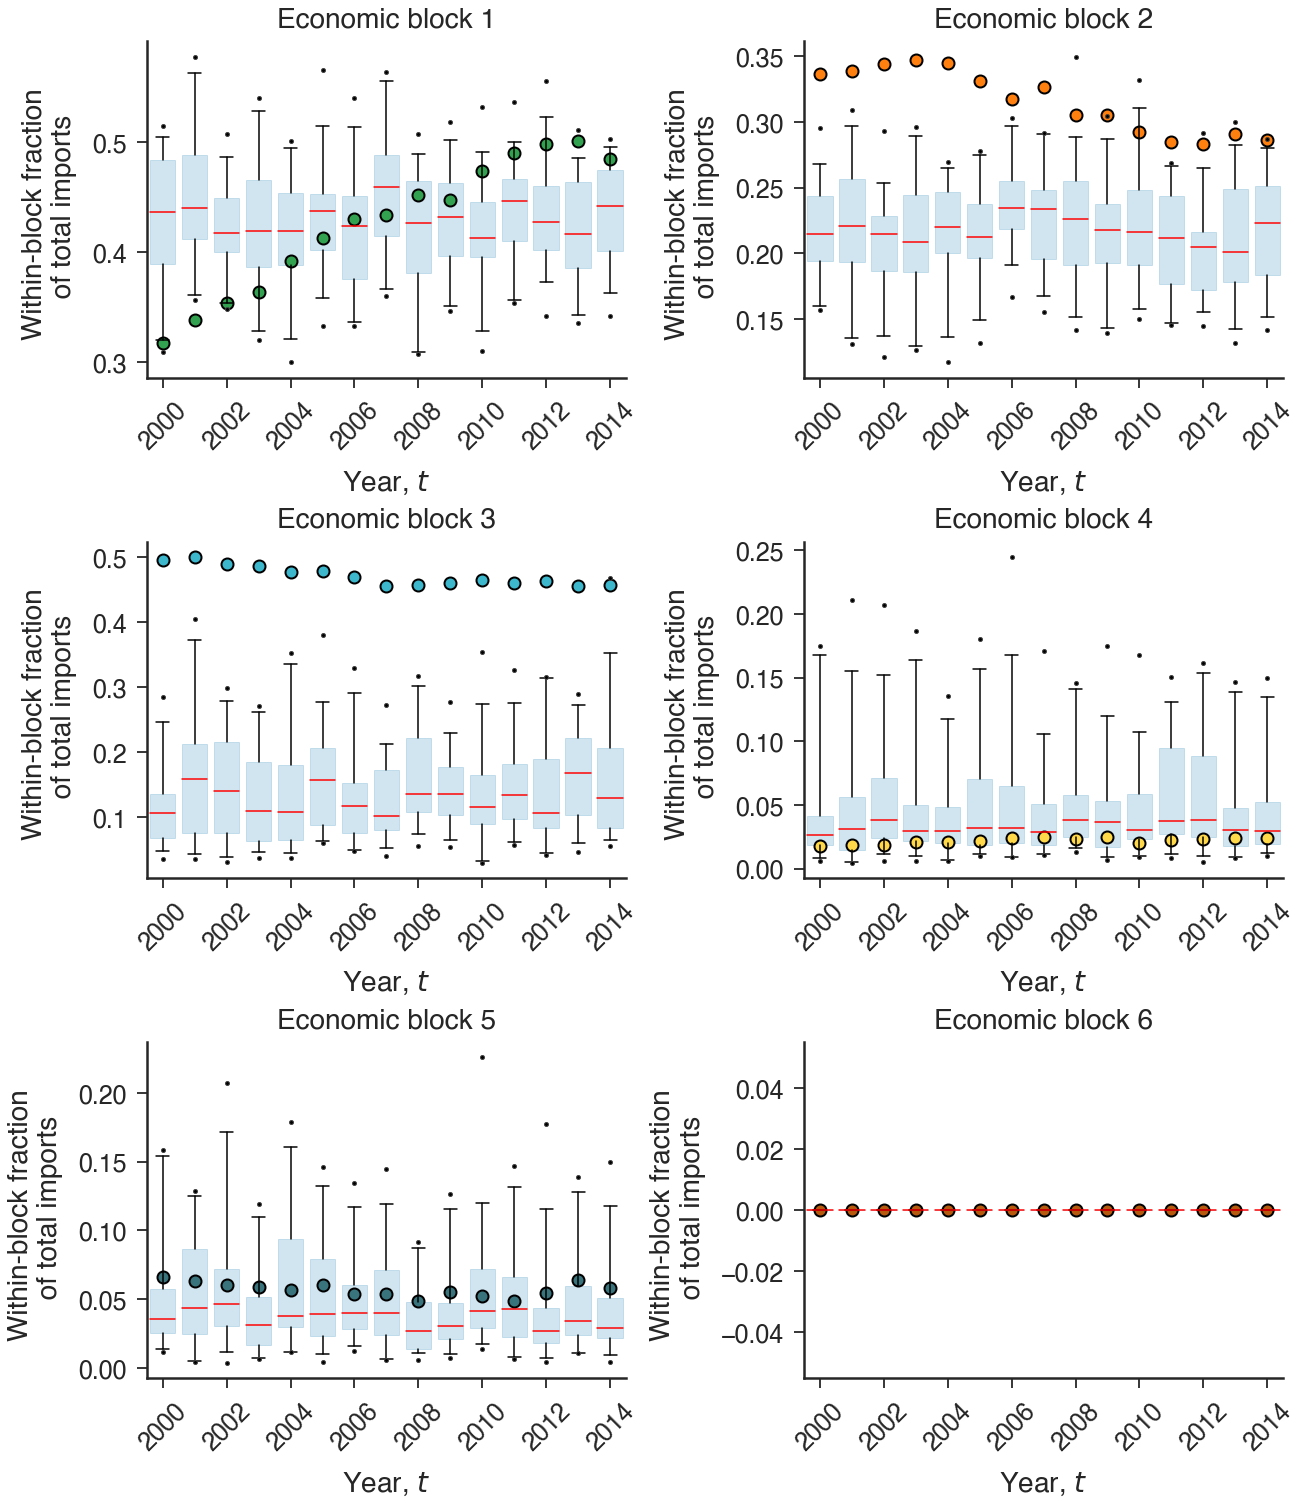

In [68]:
f, axs = plt.subplots(nrows=3, ncols=2, figsize=stdfigsize(nx=2, ny=3, scale=1))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
years=[int(i) for i in range(2000,2015)]

for i,ax in enumerate(axs.flatten()):
    ax.plot(np.array(buyers_results[i][0]),       
             marker='o',
             color=color_for[i],
             markeredgecolor='k',
             markeredgewidth=2,
             markersize=12,
             linewidth=0)

    boxprops = dict(linewidth=1,color='#67a9cf',alpha=0.3)
    flierprops = dict(marker='.', markerfacecolor='k', markersize=8, linestyle='none')
    whiskerprops = dict(linewidth=1.5, color='k')
    medianprops=dict(linewidth=1.5, color='r')
    capprops=dict(linewidth=1.5, color='k')

    df_group=pd.DataFrame(np.array(buyers_results[i][1]),index=years).T
    sns.boxplot(data=df_group,linewidth=2,ax=ax,fliersize=3,whis=[2.5, 97.5],
                capprops=capprops,
                flierprops=flierprops, 
                boxprops=boxprops, 
                whiskerprops=whiskerprops,
                medianprops=medianprops)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title('Economic block {}'.format(i+1))
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(r'Year, $t$')
    ax.set_ylabel('Within-block fraction \n of total imports')
    custom_frame(ax)
f.tight_layout()
plt.savefig('../figures/box_plot_imports.pdf',bbox_inches='tight')

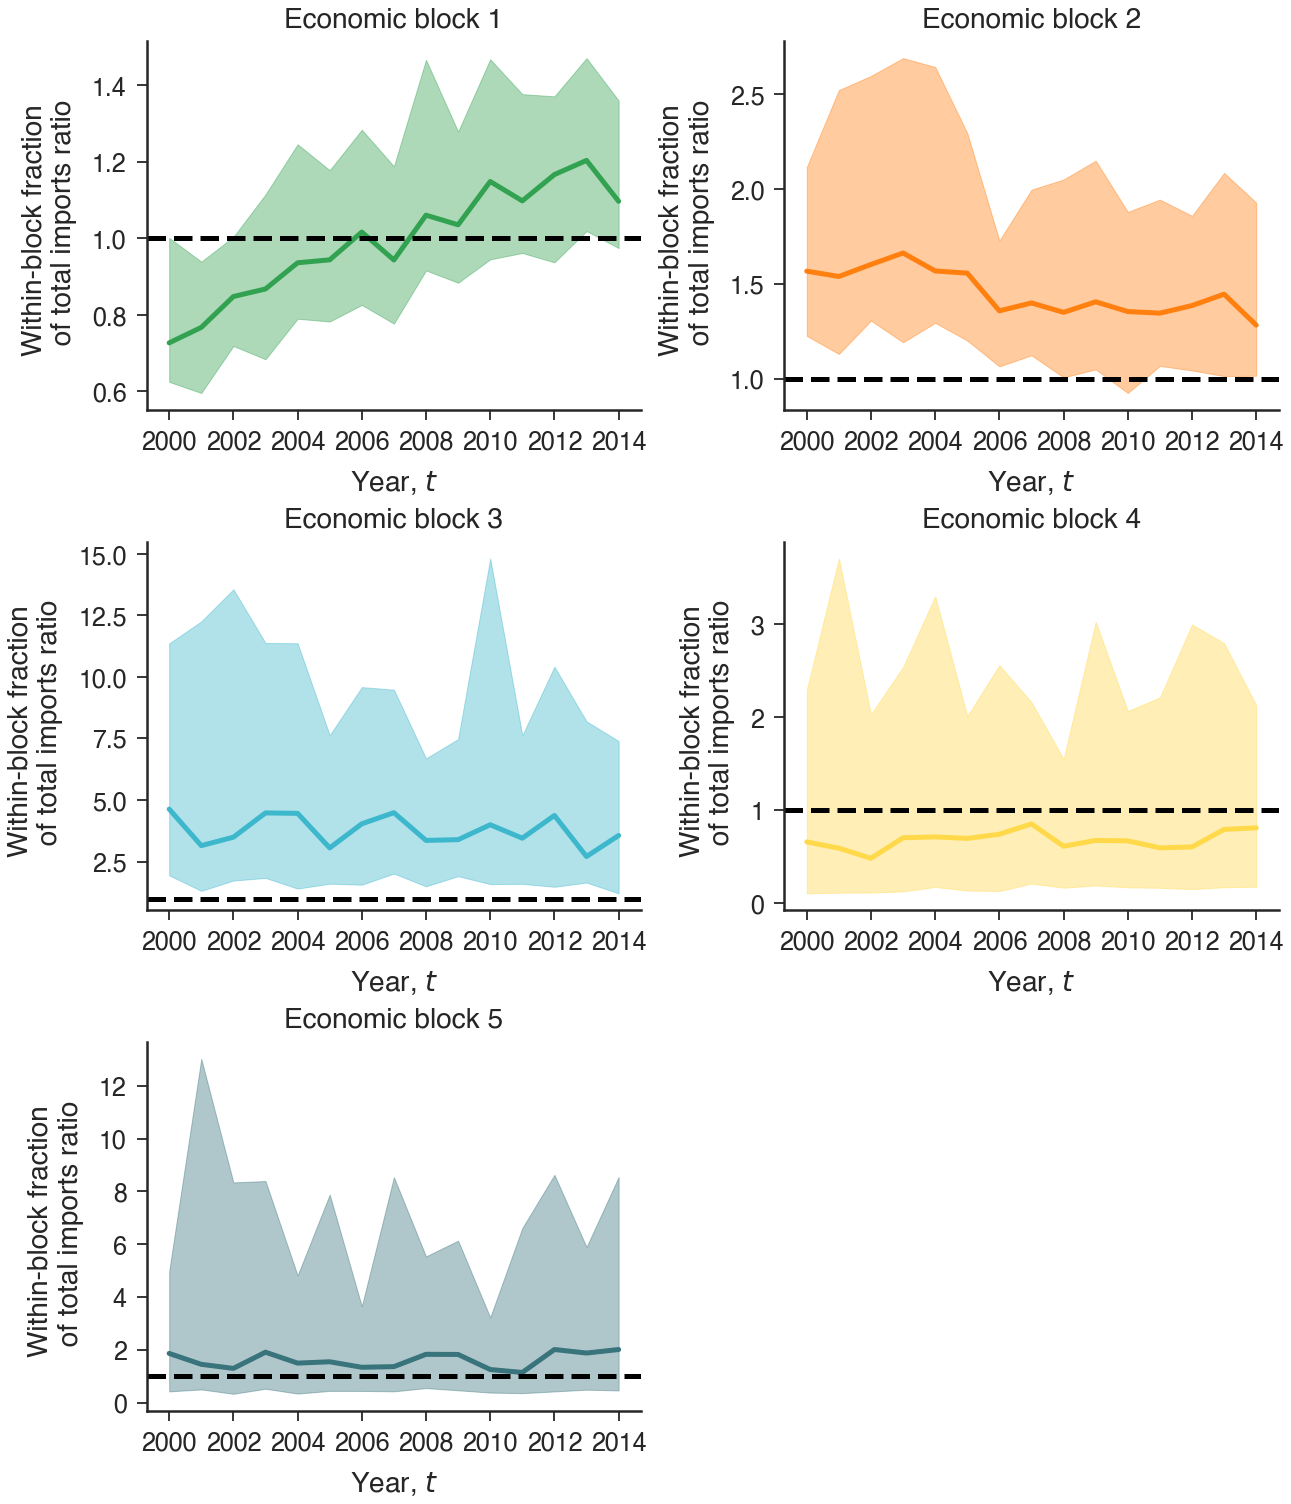

In [69]:
f, axs = plt.subplots(nrows=3, ncols=2, figsize=stdfigsize(nx=2, ny=3, scale=1))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
years=[int(i) for i in range(2000,2015)]

for i,ax in enumerate(axs.flatten()[:-1]):
    ratio=np.transpose([np.array(buyers_results[i][0])/np.transpose(buyers_results[i][1])[k] for k in range(0,30)])
    ax.fill_between(years,
                    np.percentile(ratio,2.5,axis=1),
                    np.percentile(ratio,97.5,axis=1),
                    color=color_for[i],alpha=0.4)
    ax.plot(years,np.median(ratio,axis=1),color=color_for[i])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title('Economic block {}'.format(i+1))
    ax.axhline(y=1,color='k',linestyle='dashed')
    ax.set_xlabel(r'Year, $t$')
    ax.set_ylabel('Within-block fraction \n of total imports ratio')
    custom_frame(ax)
f.tight_layout()

for ax in axs.flatten()[5:]:
    f.delaxes(ax)
plt.savefig('../figures/imports_null_ratio.pdf',bbox_inches='tight')

### Purchases by block 

In [70]:
global_fraction=dict()
fraction_within_group=dict()
for group in np.unique(best_clustering_labels):
    total_fraction=[]
    within_group=[]
    for i in range(0,15):
        df=edge_dfbyyear[i].groupby(['source_node','destination_node']).sum()
        df=df.reset_index()[['source_node','destination_node','weight']]

        df['source_node']=df['source_node'].map(countrymap)
        df['destination_node']=df['destination_node'].map(countrymap)

        group_value=df[df['destination_node'].isin(df_buyers.columns[best_clustering_labels==group])]
        total_fraction.append(group_value['weight'].sum()/df['weight'].sum())
        sub_df=df[df['destination_node'].isin(df_buyers.columns[best_clustering_labels==group])]
        within_fraction=sub_df[sub_df['source_node'].isin(df_buyers.columns[best_clustering_labels==group])]
        within_group.append(within_fraction['weight'].sum()/sub_df['weight'].sum())

    total_fraction=np.array(total_fraction)
    global_fraction[group]=total_fraction
    
    within_group=np.array(within_group)
    fraction_within_group[group]=within_group

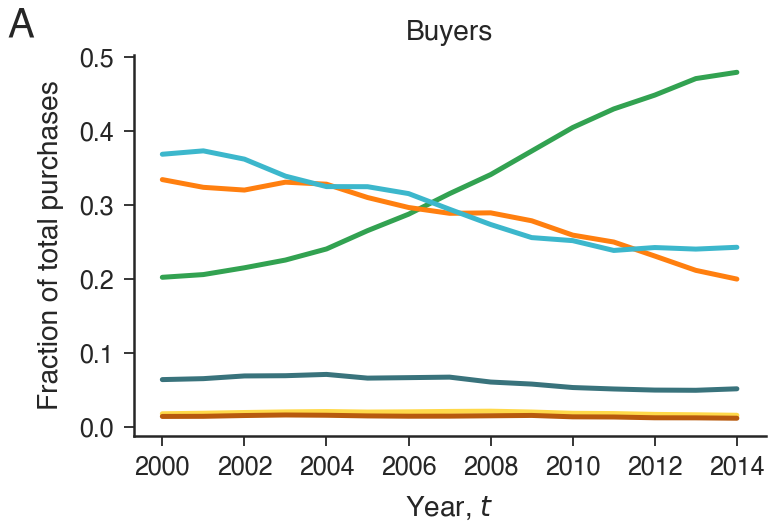

In [71]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),global_fraction[group],color=color_for[group-1],label=group)
ax.set_ylabel(r"Fraction of total purchases")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Buyers')
custom_frame(ax)
#ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic block')
ax.annotate('A', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/global_fraction_buyers.pdf',bbox_inches='tight')

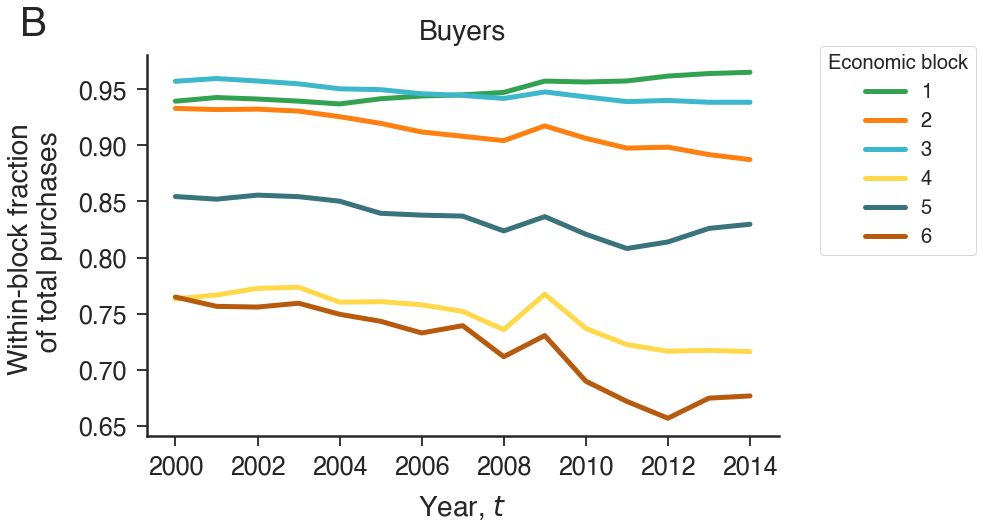

In [72]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),fraction_within_group[group],color=color_for[group-1],label=group)
ax.set_ylabel("Within-block fraction \n of total purchases")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Buyers')
custom_frame(ax)
ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic block')
ax.annotate('B', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/within_fraction_buyers.pdf',bbox_inches='tight')

### Imports by blocks 

In [73]:
global_fraction=dict()
fraction_within_group=dict()
for group in np.unique(best_clustering_labels):
    total_fraction=[]
    within_group=[]
    for i in range(0,15):
        df=edge_dfbyyear[i]
        df=df[df['source_node']!=df['destination_node']]
        df=df.groupby(['source_node','destination_node']).sum()
        df=df.reset_index()[['source_node','destination_node','weight']]

        df['source_node']=df['source_node'].map(countrymap)
        df['destination_node']=df['destination_node'].map(countrymap)

        group_value=df[df['destination_node'].isin(df_buyers.columns[best_clustering_labels==group])]
        total_fraction.append(group_value['weight'].sum()/df['weight'].sum())
        sub_df=df[df['destination_node'].isin(df_buyers.columns[best_clustering_labels==group])]
        within_fraction=sub_df[sub_df['source_node'].isin(df_buyers.columns[best_clustering_labels==group])]
        within_group.append(within_fraction['weight'].sum()/sub_df['weight'].sum())

    total_fraction=np.array(total_fraction)
    global_fraction[group]=total_fraction
    
    within_group=np.array(within_group)
    fraction_within_group[group]=within_group

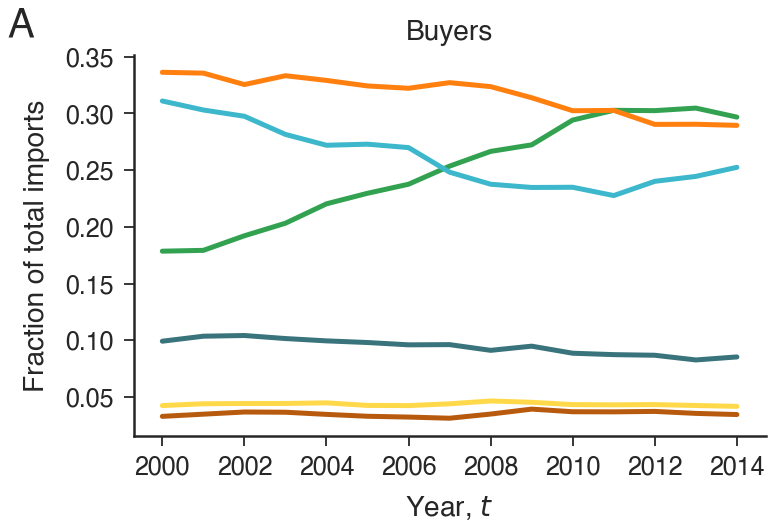

In [74]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),global_fraction[group],color=color_for[group-1],label=group)
ax.set_ylabel(r"Fraction of total imports")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Buyers')
custom_frame(ax)
#ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic block')
ax.annotate('A', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/global_fraction_imports.pdf',bbox_inches='tight')

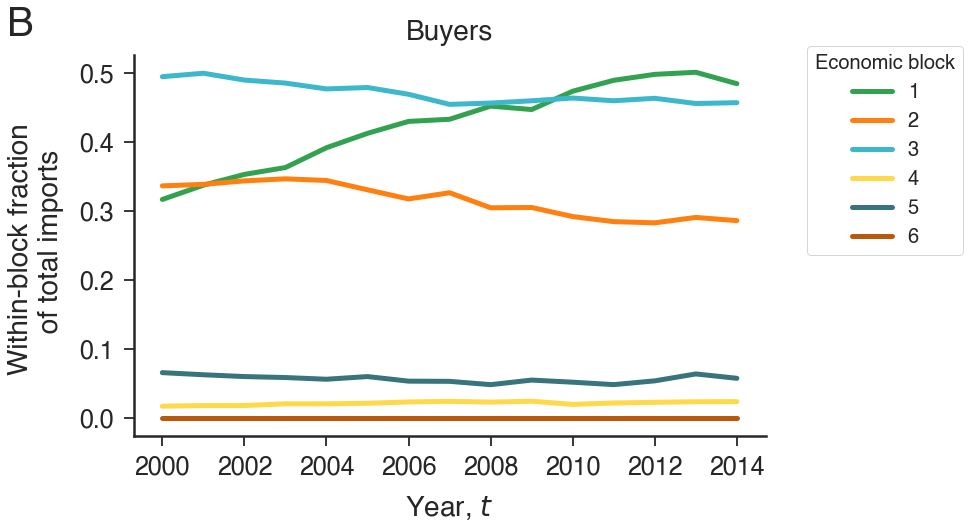

In [75]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),fraction_within_group[group],color=color_for[group-1],label=group)
ax.set_ylabel("Within-block fraction \n of total imports")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Buyers')
custom_frame(ax)
ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic block')
ax.annotate('B', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/within_fraction_imports.pdf',bbox_inches='tight')

### Domestic trade by block 

In [76]:
global_fraction=dict()
fraction_within_group=dict()

for group in np.unique(best_clustering_labels):
    total_fraction=[]
    within_group=[]
    domestic_frac=[]
    for i in range(0,15):
        df=edge_dfbyyear[i].groupby(['source_node','destination_node']).sum()
        df=df.reset_index()[['source_node','destination_node','weight']]

        df['source_node']=df['source_node'].map(countrymap)
        df['destination_node']=df['destination_node'].map(countrymap)

        group_value=df[df['destination_node'].isin(df_buyers.columns[best_clustering_labels==group])]
        group_value=group_value[group_value['source_node']==group_value['destination_node']]
                                
        total_fraction.append(group_value['weight'].sum()/df['weight'].sum())
        sub_df=df[df['destination_node'].isin(df_buyers.columns[best_clustering_labels==group])]
        within_fraction=sub_df[sub_df['source_node'].isin(df_buyers.columns[best_clustering_labels==group])]
        within_fraction=within_fraction[within_fraction['source_node']==within_fraction['destination_node']]             
        within_group.append(within_fraction['weight'].sum()/sub_df['weight'].sum())
       
    total_fraction=np.array(total_fraction)
    global_fraction[group]=total_fraction
    
    within_group=np.array(within_group)
    fraction_within_group[group]=within_group


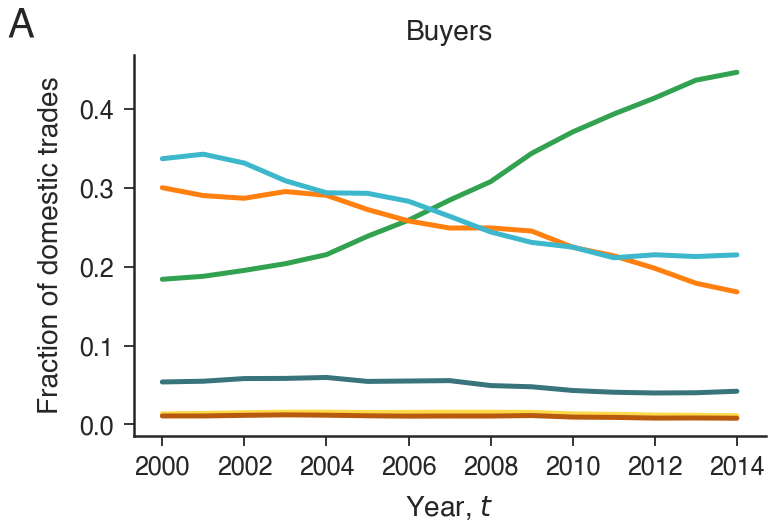

In [77]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),global_fraction[group],color=color_for[group-1],label=group)
ax.set_ylabel(r"Fraction of domestic trades")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Buyers')
custom_frame(ax)
#ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic block')
ax.annotate('A', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/domestic_fraction_buyers.pdf',bbox_inches='tight')

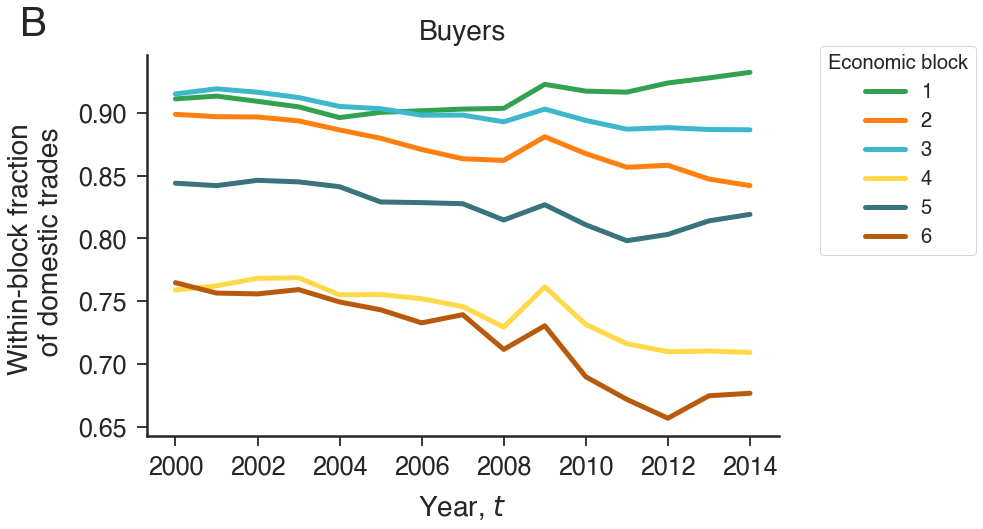

In [78]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),fraction_within_group[group],color=color_for[group-1],label=group)
ax.set_ylabel("Within-block fraction \n of domestic trades")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Buyers')
custom_frame(ax)
ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic block')
ax.annotate('B', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/within_fraction_domestic_buyers.pdf',bbox_inches='tight')

### Map 

In [79]:
countries=pd.read_csv("../data/countries.csv",delimiter=",",index_col=None)
countries.head()

Country Abbreviation   Latitude   Longitude
0  Australia          AUS -25.274398  133.775136
1    Austria          AUT  47.516231   14.550072
2    Belgium          BEL  50.503887    4.469936
3   Bulgaria          BGR  42.733883   25.485830
4     Brazil          BRA -14.235004  -51.925280

In [80]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import cartopy.crs as ccrs
import cartopy as cartopy
import cartopy.io.shapereader as shpreader

In [81]:
def plot_country(ax, country, color) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == country: 
            try:
                ax.add_geometries(n.geometry, 
                                  ccrs.PlateCarree(), 
                                  facecolor=color, 
                                  alpha = 1.00, 
                                  linewidth =0.15, 
                                  edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            except Exception as e:
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, 
                                  ccrs.PlateCarree(),
                                  facecolor=color, 
                                  alpha = 1.00,
                                  linewidth =0.15, 
                                  edgecolor = "black", 
                                  label=n.attributes['ADM0_A3']) 
    return ax

In [82]:
clusters=np.transpose([df_buyers.columns,best_clustering_labels])
df_clustering=pd.DataFrame(clusters,columns=['Country','Cluster'])
df_clustering=pd.merge(df_clustering,countries,on='Country')
color_for =  palettable.tableau.GreenOrange_6.hex_colors+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]
df_clustering['Color']=color_for_ordered
df_clustering.to_csv('../results/buyers_blocks.csv')
df_clustering.head()

Country Cluster Abbreviation   Latitude   Longitude    Color
0  Australia       1          AUS -25.274398  133.775136  #32A251
1    Austria       5          AUT  47.516231   14.550072  #39737C
2    Belgium       4          BEL  50.503887    4.469936  #FFD94A
3   Bulgaria       1          BGR  42.733883   25.485830  #32A251
4     Brazil       1          BRA -14.235004  -51.925280  #32A251

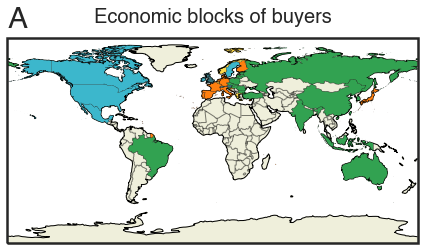

In [83]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND,zorder=-1)
# ax.add_feature(cartopy.feature.OCEAN,zorder=-1)
ax.add_feature(cartopy.feature.COASTLINE,zorder=-1)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5,zorder=-1)
#ax.add_feature(cartopy.feature.LAKES, alpha=0.95,zorder=-1)


shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries_list = reader.records()

        
for i in range(0,len(df_clustering)):

    plot_country(ax, df_clustering.loc[i].Abbreviation, color=df_clustering.loc[i].Color)

ax.set_title('Economic blocks of buyers',fontsize=20)
ax.annotate('A', xy=(0, 1.05), xycoords="axes fraction",fontsize=30,fontweight="bold")
plt.tight_layout()
plt.savefig("../figures/buyers_map.pdf",dpi=600, bbox_inches='tight')

In [84]:
# conda install geopy

In [85]:
from geopy.distance import geodesic

In [86]:
def geo_distance(X):
    import itertools
    distance=[]
    for pair in itertools.product(X, repeat=2):
        distance.append(geodesic(*pair,ellipsoid='WGS-84').kilometers)
    distance=pd.DataFrame(np.array(distance).reshape(len(X),len(X)))
    return distance

In [87]:
df_clustering.head()

Country Cluster Abbreviation   Latitude   Longitude    Color
0  Australia       1          AUS -25.274398  133.775136  #32A251
1    Austria       5          AUT  47.516231   14.550072  #39737C
2    Belgium       4          BEL  50.503887    4.469936  #FFD94A
3   Bulgaria       1          BGR  42.733883   25.485830  #32A251
4     Brazil       1          BRA -14.235004  -51.925280  #32A251

In [88]:
X=df_clustering[['Latitude','Longitude']].values
dist_matrix=geo_distance(X)
dist_matrix.columns=df_clustering.Country
dist_matrix.index=df_clustering.Country

print('Economic block&','Average distance within-block&', """Average distance between blocks""")
for i in range(1,7):
    in_cluster=df_clustering[df_clustering['Cluster']==i].Country
    out_cluster=df_clustering[df_clustering['Cluster']!=i].Country
    print(i,'&',round(np.mean(np.mean(dist_matrix[in_cluster].loc[in_cluster])),2),'&',
            round(np.mean(np.mean(dist_matrix[in_cluster].loc[out_cluster])),2),"\\\\")

Economic block& Average distance within-block& Average distance between blocks
1 & 5630.9 & 5512.42 \\
2 & 2994.43 & 4452.62 \\
3 & 4676.4 & 5914.79 \\
4 & 1234.5 & 3661.09 \\
5 & 723.47 & 3589.81 \\
6 & 0.0 & 3397.31 \\


## Sellers

### Dendrogram 

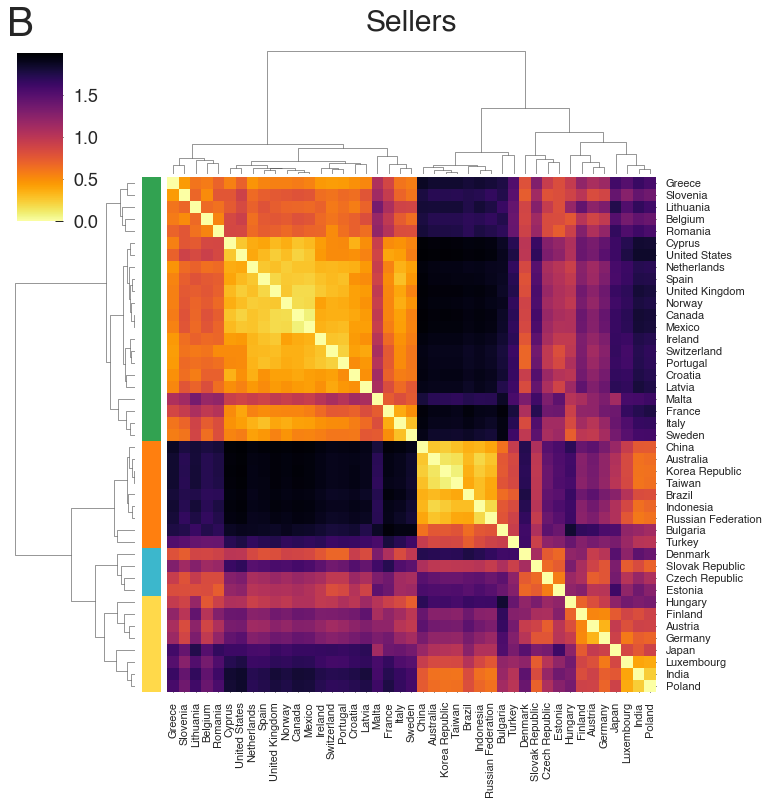

In [89]:
distances=pd_clustering_distances(df_sellers,df_sellers.columns,metric='correlation')
linkage = scipy.cluster.hierarchy.linkage(squareform(distances), method='ward')
d_thresholds,silhouettes=compute_silhouettes(distances,linkage)
firt_local_max_silhouettes,global_max_silhouettes,best_clustering_labels=best_clustering(distances,
                                                                                         linkage,
                                                                                         d_thresholds,
                                                                                         silhouettes)

color_for =  palettable.tableau.GreenOrange_6.hex_colors+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]

f = sns.clustermap(distances,
                   figsize=(13, 13),
                   linewidths=.0,
                   linecolor='w',
                   yticklabels=True,
                   xticklabels=True,
                   cmap='inferno_r',
                   col_linkage=linkage,
                   row_linkage=linkage,
#                    row_cluster=False,
#                    col_cluster=False,
                   row_colors=color_for_ordered, 
#                    cbar_pos=(-0.08, 0.75, .03, .2)
                  )

f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xticklabels(),fontsize=11);
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_yticklabels(),fontsize=11);
f.ax_heatmap.tick_params(width=1, length=5)
f.ax_heatmap.collections[0].colorbar.ax.tick_params(labelsize=18, width=1, length=8)
plt.setp(f.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.annotate('B', xy=(-0.2, 1.1), xycoords="axes fraction",fontsize=40,fontweight="bold")
f.ax_col_dendrogram.set_title('Sellers',fontsize=30)
f.ax_heatmap.set_xlabel('');
f.ax_heatmap.set_ylabel('');
f.savefig('../figures/sellers-dendrogram.pdf')

In [90]:
best_clustering_labels_sellers=best_clustering_labels

In [91]:
normalized_mutual_info_score(best_clustering_labels_sellers,v_marginal_sellers[0])

0.5639420005453716

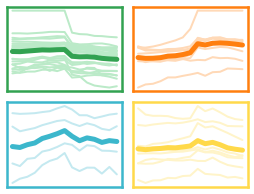

In [92]:
df_ts=df_sellers.T
df_ts['groups']=best_clustering_labels

color =  palettable.tableau.GreenOrange_6.hex_colors
f, axs = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(nx=2, ny=2, scale=0.2))

for i in range(1,len(np.unique(best_clustering_labels))+1):
    ax=axs.flatten()[i-1]
    df_group=df_ts[df_ts.groups==i][[year for year in range(2000,2015)]].T
    df_group=df_group.apply(np.log)
    df_group.plot(legend=False,ax=ax,color=lighten_color(color[i-1], amount=0.3),alpha=1,lw=2)
    df_group.mean(axis=1).plot(color=color[i-1],alpha=1,ax=ax)
    # ax.set_yscale('log')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    ax.spines['top'].set_color(color[i-1])
    ax.spines['right'].set_color(color[i-1])
    ax.spines['bottom'].set_color(color[i-1])
    ax.spines['left'].set_color(color[i-1])
    
    
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

f.tight_layout() 
f.savefig('../figures/avg_centrality_sellers.pdf')

### Within-block null model comparison 

In [93]:
sellers_results=[]
for group in np.unique(best_clustering_labels):
    group_results=[]
    real_values=[]
    for year in range(0,15):
        df=edge_dfbyyear[year].copy()
        df=df[df['source_node']!=df['destination_node']]
        df=df.groupby(['source_node','destination_node']).sum()
        df=df.reset_index()[['source_node','destination_node','weight']]
        df['source_node']=df['source_node'].map(countrymap)
        df['destination_node']=df['destination_node'].map(countrymap)
        
        sub_df_real=df[df['source_node'].isin(df_sellers.columns[best_clustering_labels==group])]
        within_fraction=sub_df_real[sub_df_real['destination_node'].isin(df_sellers.columns[best_clustering_labels==group])]

        randvalue=[]
        for i in range(0,30):
            #df_rand=randomize_links(df,'destination_node')
            #df_rand=randomize_weights_globally(df)
            df_rand=randomize_weights_locally(df,direction='source_node')
            
            sub_df=df_rand[df_rand['source_node'].isin(df_sellers.columns[best_clustering_labels==group])]
            within_fraction_rand=sub_df[sub_df['destination_node'].isin(df_sellers.columns[best_clustering_labels==group])]
            randvalue.append(within_fraction_rand['weight'].sum()/sub_df['weight'].sum())
        real_values.append(within_fraction['weight'].sum()/sub_df_real['weight'].sum())
        group_results.append(randvalue)
    sellers_results.append([real_values,group_results])


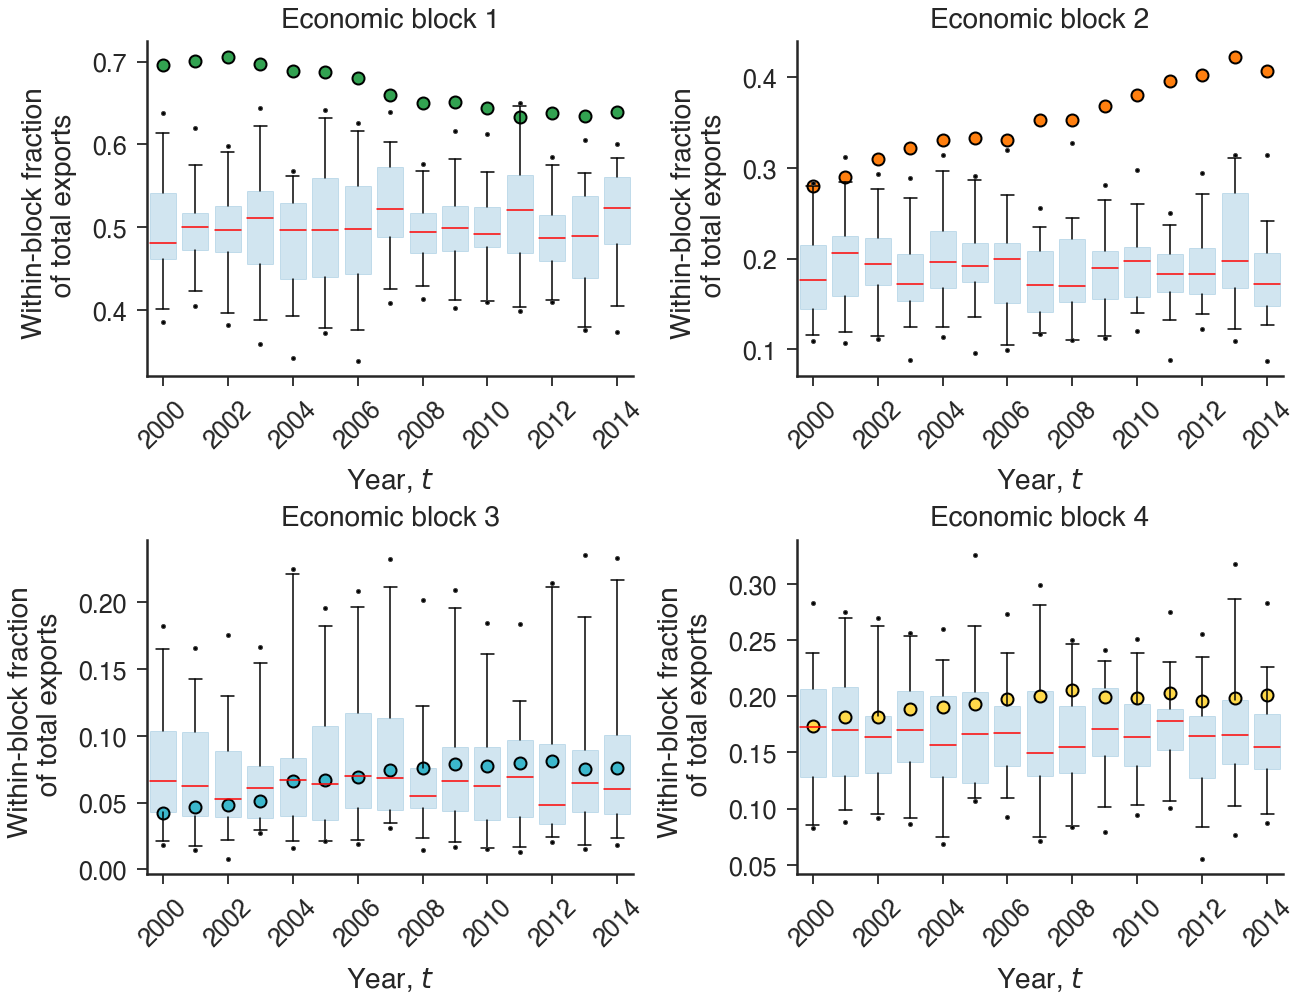

In [94]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(nx=2, ny=2, scale=1))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
years=[int(i) for i in range(2000,2015)]

for i,ax in enumerate(axs.flatten()):
    ax.plot(np.array(sellers_results[i][0]),       
             marker='o',
             color=color_for[i],
             markeredgecolor='k',
             markeredgewidth=2,
             markersize=12,
             linewidth=0)

    boxprops = dict(linewidth=1,color='#67a9cf',alpha=0.3)
    flierprops = dict(marker='.', markerfacecolor='k', markersize=8, linestyle='none')
    whiskerprops = dict(linewidth=1.5, color='k')
    medianprops=dict(linewidth=1.5, color='r')
    capprops=dict(linewidth=1.5, color='k')

    df_group=pd.DataFrame(np.array(sellers_results[i][1]),index=years).T
    sns.boxplot(data=df_group,linewidth=2,ax=ax,fliersize=3,whis=[2.5, 97.5],
                capprops=capprops,
                flierprops=flierprops, 
                boxprops=boxprops, 
                whiskerprops=whiskerprops,
                medianprops=medianprops)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title('Economic block {}'.format(i+1))
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(r'Year, $t$')
    ax.set_ylabel('Within-block fraction \n of total exports')
    custom_frame(ax)
f.tight_layout()
plt.savefig('../figures/box_plot_exports.pdf',bbox_inches='tight')

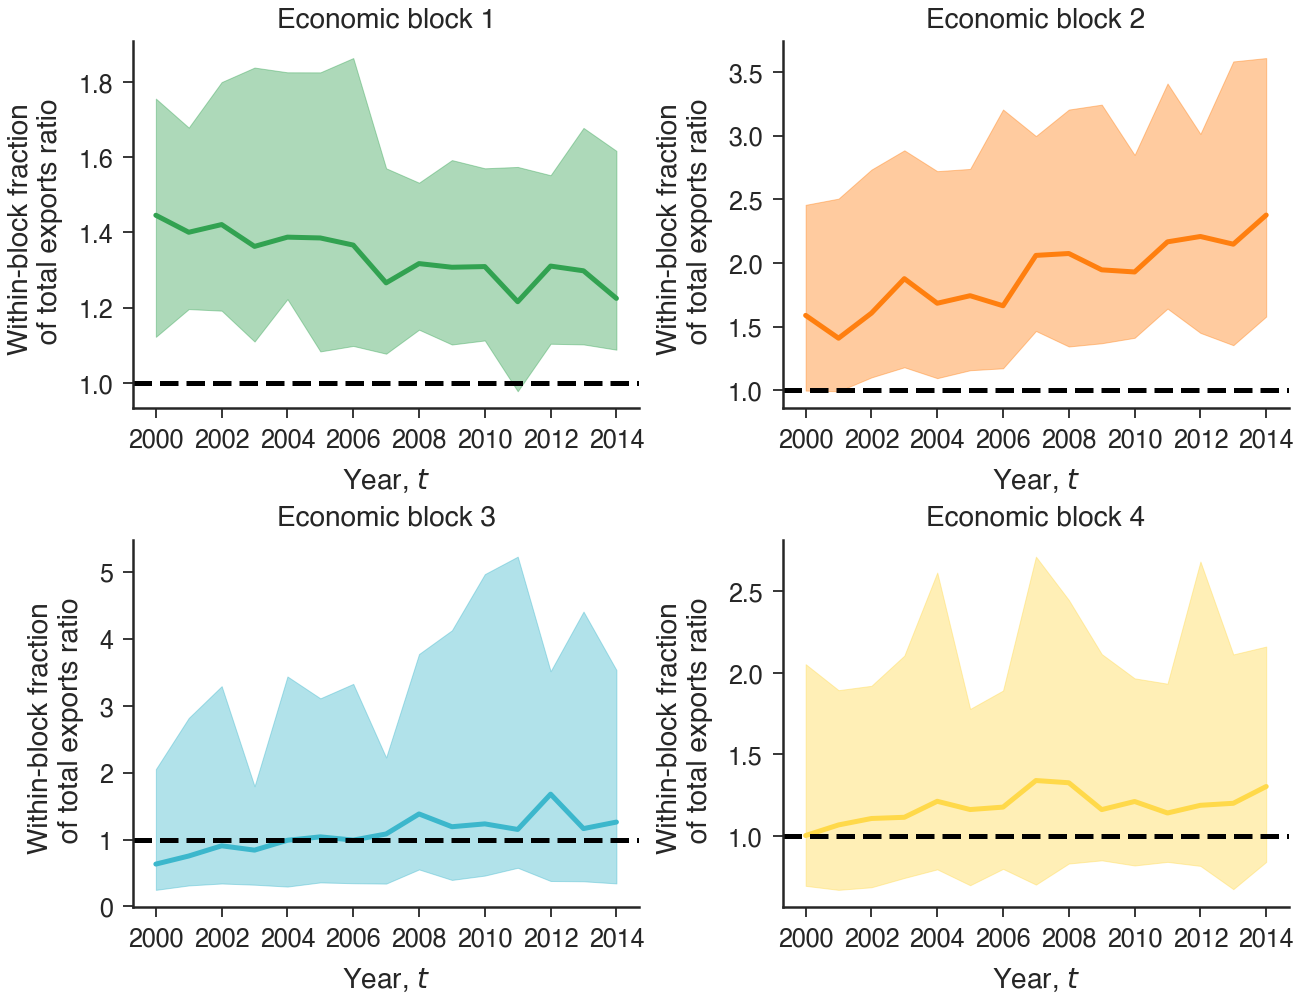

In [95]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(nx=2, ny=2, scale=1))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
years=[int(i) for i in range(2000,2015)]

for i,ax in enumerate(axs.flatten()[:]):
    ratio=np.transpose([np.array(sellers_results[i][0])/np.transpose(sellers_results[i][1])[k] for k in range(0,30)])
    ax.fill_between(years,
                    np.percentile(ratio,2.5,axis=1),
                    np.percentile(ratio,97.5,axis=1),
                    color=color_for[i],alpha=0.4)
    ax.plot(years,np.median(ratio,axis=1),color=color_for[i])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title('Economic block {}'.format(i+1))
    ax.axhline(y=1,color='k',linestyle='dashed')
    ax.set_xlabel(r'Year, $t$')
    ax.set_ylabel('Within-block fraction \n of total exports ratio')
    custom_frame(ax)
f.tight_layout()


plt.savefig('../figures/exports_null_ratio.pdf',bbox_inches='tight')

### Sales by block

In [96]:
global_fraction=dict()
fraction_within_group=dict()
for group in np.unique(best_clustering_labels):
    total_fraction=[]
    within_group=[]
    for i in range(0,15):
        df=edge_dfbyyear[i].groupby(['source_node','destination_node']).sum()
        df=df.reset_index()[['source_node','destination_node','weight']]

        df['source_node']=df['source_node'].map(countrymap)
        df['destination_node']=df['destination_node'].map(countrymap)

        group_value=df[df['source_node'].isin(df_sellers.columns[best_clustering_labels==group])]
        total_fraction.append(group_value['weight'].sum()/df['weight'].sum())
        sub_df=df[df['source_node'].isin(df_sellers.columns[best_clustering_labels==group])]
        within_fraction=sub_df[sub_df['destination_node'].isin(df_sellers.columns[best_clustering_labels==group])]
        within_group.append(within_fraction['weight'].sum()/sub_df['weight'].sum())

    total_fraction=np.array(total_fraction)
    global_fraction[group]=total_fraction
    
    within_group=np.array(within_group)
    fraction_within_group[group]=within_group

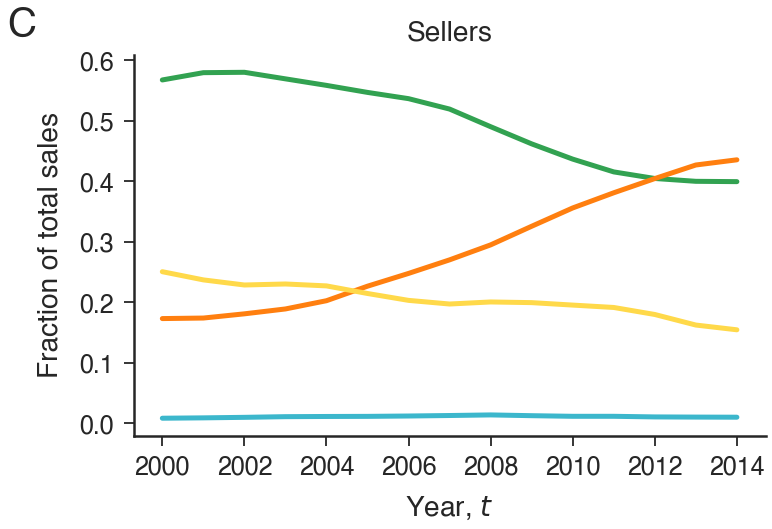

In [97]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),global_fraction[group],color=color_for[group-1],label=group)
ax.set_ylabel(r"Fraction of total sales")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Sellers')
custom_frame(ax)
# ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic blocks')
plt.annotate('C', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/global_fraction_sellers.pdf',bbox_inches='tight')

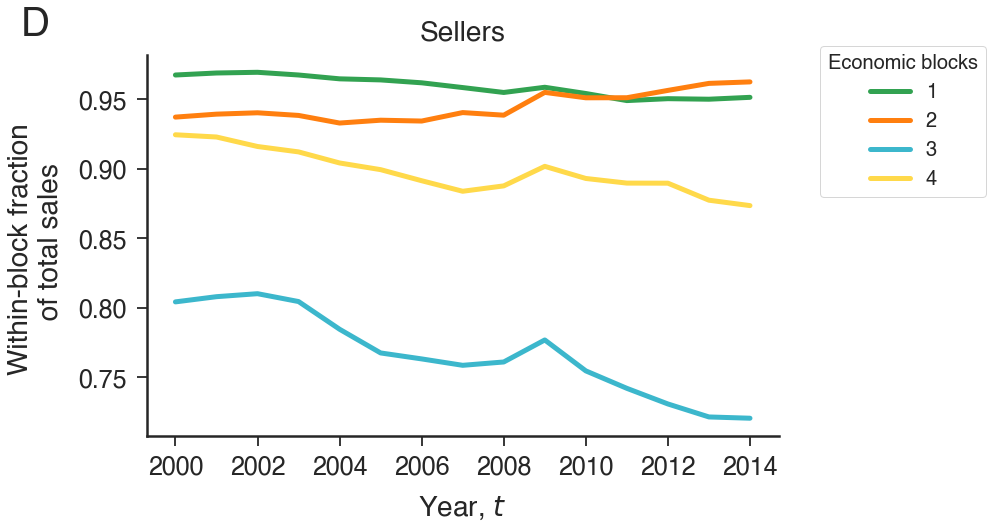

In [98]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),fraction_within_group[group],color=color_for[group-1],label=group)
ax.set_ylabel("Within-block fraction \n of total sales")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Sellers')
custom_frame(ax)
ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic blocks')
ax.annotate('D', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/within_fraction_sellers.pdf',bbox_inches='tight')

### Exports by block 

In [99]:
global_fraction=dict()
fraction_within_group=dict()
for group in np.unique(best_clustering_labels):
    total_fraction=[]
    within_group=[]
    for i in range(0,15):
        df=edge_dfbyyear[i]
        df=df[df['source_node']!=df['destination_node']]
        df=df.groupby(['source_node','destination_node']).sum()
        df=df.reset_index()[['source_node','destination_node','weight']]

        df['source_node']=df['source_node'].map(countrymap)
        df['destination_node']=df['destination_node'].map(countrymap)

        group_value=df[df['source_node'].isin(df_sellers.columns[best_clustering_labels==group])]
        total_fraction.append(group_value['weight'].sum()/df['weight'].sum())
        sub_df=df[df['source_node'].isin(df_sellers.columns[best_clustering_labels==group])]
        within_fraction=sub_df[sub_df['destination_node'].isin(df_sellers.columns[best_clustering_labels==group])]
        within_group.append(within_fraction['weight'].sum()/sub_df['weight'].sum())

    total_fraction=np.array(total_fraction)
    global_fraction[group]=total_fraction
    
    within_group=np.array(within_group)
    fraction_within_group[group]=within_group

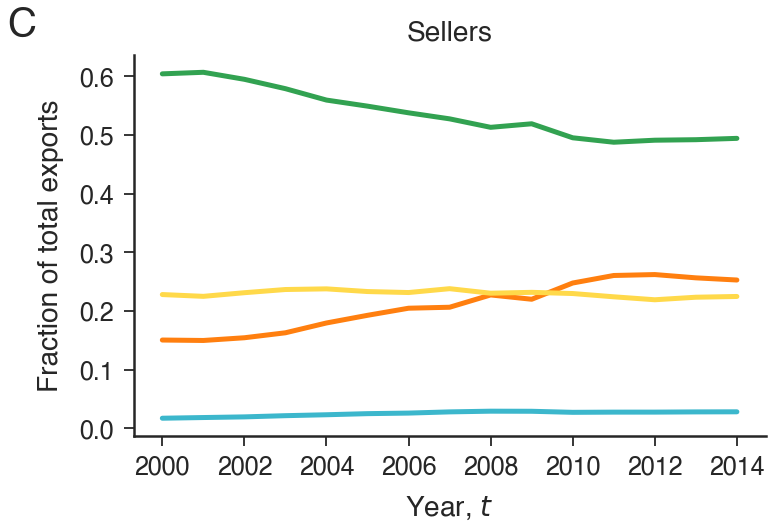

In [100]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),global_fraction[group],color=color_for[group-1],label=group)
ax.set_ylabel(r"Fraction of total exports")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Sellers')
custom_frame(ax)
# ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic blocks')
plt.annotate('C', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/global_fraction_exports.pdf',bbox_inches='tight')

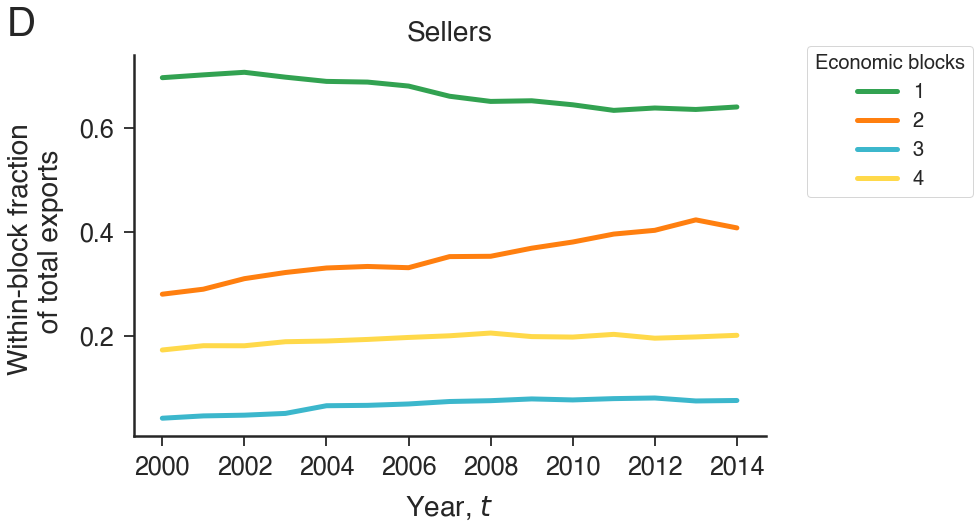

In [101]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),fraction_within_group[group],color=color_for[group-1],label=group)
ax.set_ylabel("Within-block fraction \n of total exports")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Sellers')
custom_frame(ax)
ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic blocks')
ax.annotate('D', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/within_fraction_exports.pdf',bbox_inches='tight')

### Domestic trade by block 

In [102]:
global_fraction=dict()
fraction_within_group=dict()

for group in np.unique(best_clustering_labels):
    total_fraction=[]
    within_group=[]
    domestic_frac=[]
    for i in range(0,15):
        df=edge_dfbyyear[i].groupby(['source_node','destination_node']).sum()
        df=df.reset_index()[['source_node','destination_node','weight']]

        df['source_node']=df['source_node'].map(countrymap)
        df['destination_node']=df['destination_node'].map(countrymap)

        group_value=df[df['destination_node'].isin(df_sellers.columns[best_clustering_labels==group])]
        group_value=group_value[group_value['source_node']==group_value['destination_node']]
                                
        total_fraction.append(group_value['weight'].sum()/df['weight'].sum())
        sub_df=df[df['destination_node'].isin(df_sellers.columns[best_clustering_labels==group])]
        within_fraction=sub_df[sub_df['source_node'].isin(df_sellers.columns[best_clustering_labels==group])]
        within_fraction=within_fraction[within_fraction['source_node']==within_fraction['destination_node']]             
        within_group.append(within_fraction['weight'].sum()/sub_df['weight'].sum())
       
    total_fraction=np.array(total_fraction)
    global_fraction[group]=total_fraction
    
    within_group=np.array(within_group)
    fraction_within_group[group]=within_group


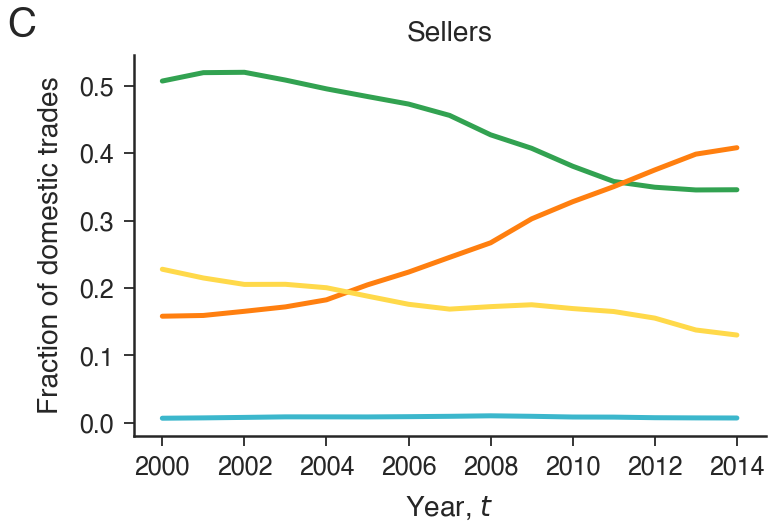

In [103]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),global_fraction[group],color=color_for[group-1],label=group)
ax.set_ylabel(r"Fraction of domestic trades")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Sellers')
custom_frame(ax)
#ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic block')
ax.annotate('C', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/domestic_fraction_sellers.pdf',bbox_inches='tight')

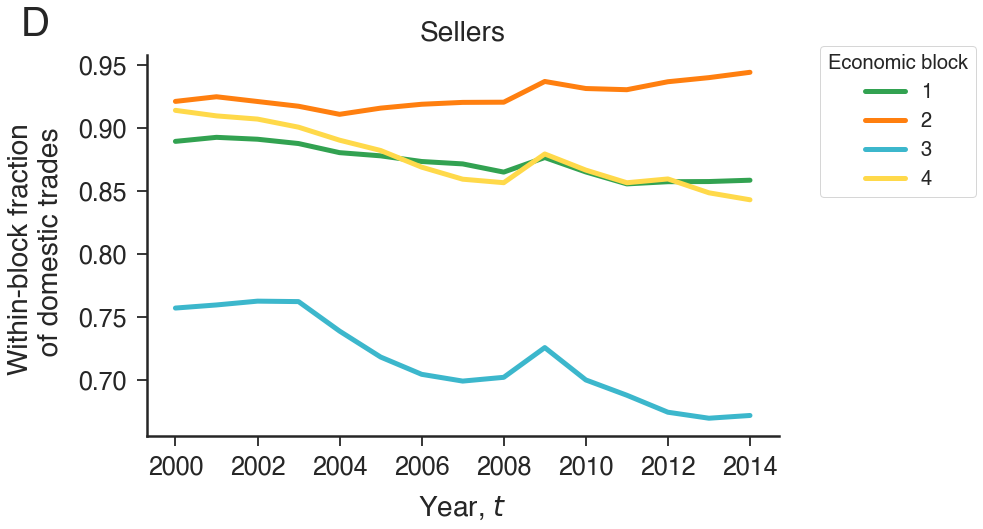

In [104]:
fig, ax = plt.subplots(figsize=(xs,ys))
color_for =  palettable.tableau.GreenOrange_6.hex_colors#+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]
for group in np.unique(best_clustering_labels):
    ax.plot(np.arange(2000,2015,1),fraction_within_group[group],color=color_for[group-1],label=group)
ax.set_ylabel("Within-block fraction \n of domestic trades")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Sellers')
custom_frame(ax)
ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20,title='Economic block')
ax.annotate('D', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
plt.savefig('../figures/within_fraction_domestic_sellers.pdf',bbox_inches='tight')

### Map 

In [105]:
clusters=np.transpose([df_sellers.columns,best_clustering_labels])
df_clustering=pd.DataFrame(clusters,columns=['Country','Cluster'])
df_clustering=pd.merge(df_clustering,countries,on='Country')
color_for =  palettable.tableau.GreenOrange_6.hex_colors+palettable.tableau.Tableau_20.hex_colors
color_for_ordered = [color_for[x] for x in best_clustering_labels-1]
df_clustering['Color']=color_for_ordered
df_clustering.to_csv('../results/sellers_blocks.csv')
df_clustering.head()

Country Cluster Abbreviation   Latitude   Longitude    Color
0  Australia       2          AUS -25.274398  133.775136  #FF7F0F
1    Austria       4          AUT  47.516231   14.550072  #FFD94A
2    Belgium       1          BEL  50.503887    4.469936  #32A251
3   Bulgaria       2          BGR  42.733883   25.485830  #FF7F0F
4     Brazil       2          BRA -14.235004  -51.925280  #FF7F0F

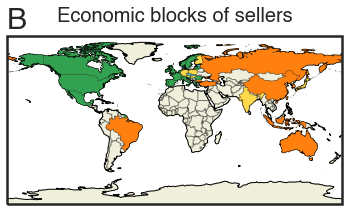

In [106]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND,zorder=-1)
# ax.add_feature(cartopy.feature.OCEAN,zorder=-1)
ax.add_feature(cartopy.feature.COASTLINE,zorder=-1)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5,zorder=-1)
#ax.add_feature(cartopy.feature.LAKES, alpha=0.95,zorder=-1)


shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries_list = reader.records()

        
for i in range(0,len(df_clustering)):

    plot_country(ax, df_clustering.loc[i].Abbreviation, color=df_clustering.loc[i].Color)

ax.set_title('Economic blocks of sellers',fontsize=20)
ax.annotate('B', xy=(0, 1.05), xycoords="axes fraction",fontsize=30,fontweight="bold")
plt.savefig("../figures/sellers_map.pdf",dpi=600, bbox_inches='tight')

In [107]:
dist_matrix[in_cluster].loc[in_cluster]

Country      Netherlands
Country                 
Netherlands          0.0

In [108]:
X=df_clustering[['Latitude','Longitude']].values
dist_matrix=geo_distance(X)
dist_matrix.columns=df_clustering.Country
dist_matrix.index=df_clustering.Country

print('Economic block&','Average distance within-block&', """Average distance between blocks""")
for i in range(1,5):
    in_cluster=df_clustering[df_clustering['Cluster']==i].Country
    out_cluster=df_clustering[df_clustering['Cluster']!=i].Country
    print(i,'&',round(np.mean(np.mean(dist_matrix[in_cluster].loc[in_cluster])),2),'&',
            round(np.mean(np.mean(dist_matrix[in_cluster].loc[out_cluster])),2),"\\\\")

Economic block& Average distance within-block& Average distance between blocks
1 & 3129.63 & 5422.89 \\
2 & 7187.36 & 7875.84 \\
3 & 690.5 & 3523.01 \\
4 & 3489.43 & 4532.31 \\


# Inverse participation ratio


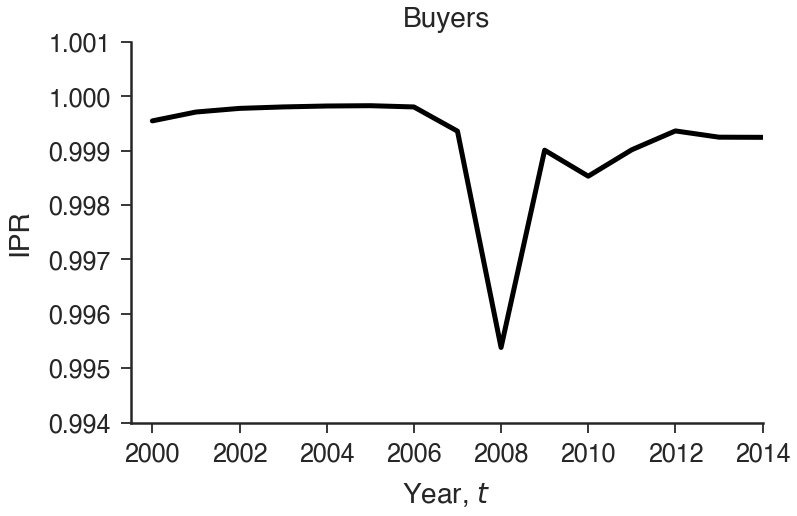

In [109]:
fig, ax = plt.subplots(figsize=(xs,ys))


x=[i for i in range(2000,2015)]
ipr_buyers=np.array([np.sum(multilayer_buyers[2000+i]**4) for i in range(0,15)])
ax.plot(x,ipr_buyers,marker='o',
        color='k',#'#abdda4',
        markeredgecolor='k',
        markersize=0,
        linewidth=5,
       label='Multilayer',zorder=10)


# ax.axvline(x=2008,color='#bdbdbd',linestyle='-',linewidth=30,zorder=-10)
ax.set_xlim(1999.5,2014)
ax.set_ylim(0.994,1.001)

custom_frame(ax)
ax.set_ylabel(r"IPR")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Buyers')
plt.savefig("../figures/ipr_buyers.pdf",bbox_inches='tight')

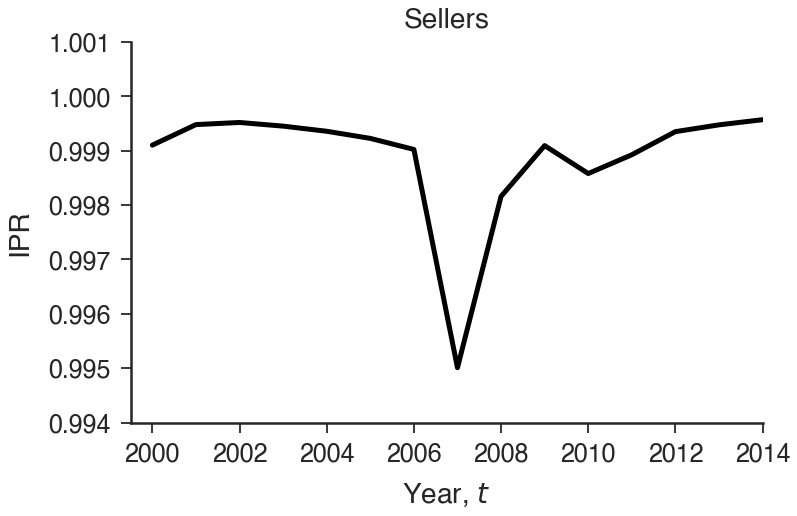

In [110]:
fig, ax = plt.subplots(figsize=(xs,ys))



x=[i for i in range(2000,2015)]
ipr_sellers=np.array([np.sum(multilayer_sellers[2000+i]**4) for i in range(0,15)])
ax.plot(x,ipr_sellers,marker='o',
        color='k',#'#abdda4',
        markeredgecolor='k',
        markersize=0,
        linewidth=5,
       label='Multilayer',zorder=10)


# ax.axvline(x=2008,color='#bdbdbd',linestyle='-',linewidth=30,zorder=-10)
ax.set_xlim(1999.5,2014)
ax.set_ylim(0.994,1.001)

custom_frame(ax)
ax.set_ylabel(r"IPR")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Sellers')
plt.savefig("../figures/ipr_sellers.pdf",bbox_inches='tight')

# Contribution of each layer

In [111]:
def diagram_centrality(M,node_labels,n_layers,n_nodes):
    """
    
    """
    import scipy as sp
    from scipy.sparse import linalg 
    eigenvalue, eigenvector = linalg.eigs(M.T, k=1, which='LR')
    largest = eigenvector.flatten().real
    norm = sp.sign(largest.sum())*sp.linalg.norm(largest)
    centrality = largest/norm
    centrality=centrality.reshape((n_layers,n_nodes))
    u=np.array([1 for i in range(0,n_layers)])
    centralitymnet=u.dot(centrality)
    if node_labels==False:
         centralitymnet=dict(zip(np.arange(0,len(centralitymnet)),centralitymnet))
    else:
        centralitymnet=dict(zip(node_labels,centralitymnet))
    return centrality,centralitymnet

In [112]:
centrality=[]
for i in range(0,len(m_list)):
    m=m_list[i].copy()
    ec,centralitymnet=diagram_centrality(m.T,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43)
    centrality.append(ec)

lipr=[]
for j in range(0,56):
    l=[np.sum(centrality[i][j]**4)/np.sum(centrality[i][j]**2)**2 for i in range(0,15)]
    lipr.append(l)

In [113]:
buyers_total=[]
sellers_total=[]
for i in range(0,15):
    df=edge_dfbyyear[i].groupby(by='destination_layer').sum().reset_index()[['destination_layer','weight']]
    buyers_total.append(df['weight'].values)
    
    df=edge_dfbyyear[i].groupby(by='source_layer').sum().reset_index()[['source_layer','weight']]
    sellers_total.append(df['weight'].values)

In [114]:
results=[]
for i in range(0,56):
    r,p=stats.pearsonr(lipr[i],np.transpose(buyers_total)[i])
    results.append([sectors.loc[i].Code,sectors.loc[i].Activity,r,p])

In [115]:
df=pd.DataFrame(results,columns=['Code','Activity','r','p'])
df['p<0.05/56']=df['p']<0.05/56
df=df.sort_values('p')
df[:10]

Code                                           Activity         r  \
19         C29  Manufacture of motor vehicles, trailers and se...  0.809540   
47         M73                    Advertising and market research -0.809466   
32         H51                                      Air transport -0.781092   
27         G45  Wholesale and retail trade and repair of motor... -0.778066   
22         C33  Repair and installation of machinery and equip... -0.770815   
6          C16  Manufacture of wood and of products of wood an...  0.745623   
37  J59$\_$J60  Motion picture, video and television programme... -0.721511   
7          C17            Manufacture of paper and paper products  0.714683   
45         M71  Architectural and engineering activities; tech... -0.683996   
3            B                               Mining and quarrying  0.676504   

           p  p<0.05/56  
19  0.000255       True  
47  0.000256       True  
32  0.000586       True  
27  0.000636       True  
22  0.000769       True  
6   0.001417      False  
37  0.002395      False  
7   0.002752      False  
45  0.004921      False  
3   0.005615      False

5


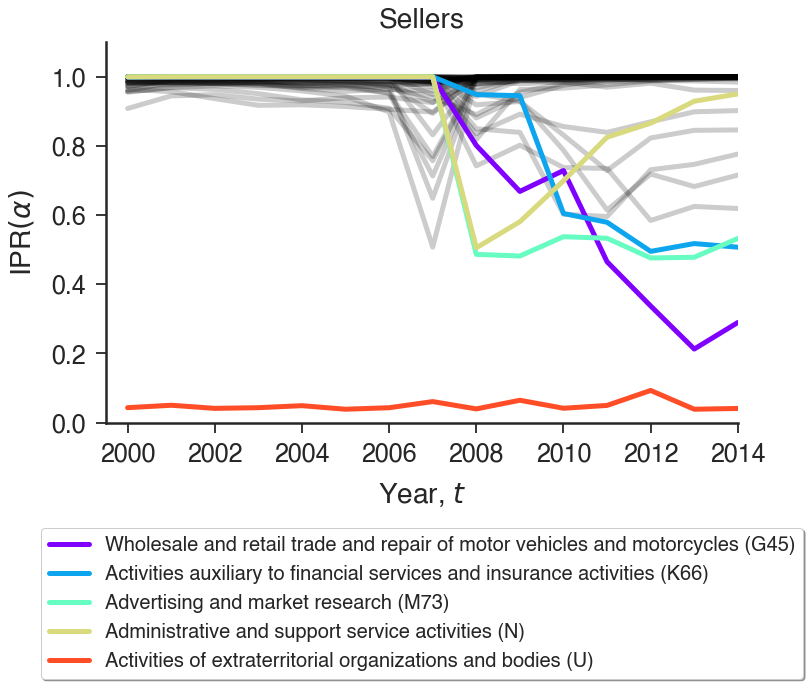

In [116]:
fig, ax = plt.subplots(figsize=(xs,ys))
colormap = plt.cm.rainbow
colors=[colormap(i) for i in np.linspace(0, 0.9,5)]
count=0
for i in range(0,56):
    if min(lipr[i])>0.507:
        ax.plot(x,lipr[i],marker='o',
                color='k',
                linewidth=5,
                markeredgecolor='k',
                markersize=0,
                alpha=0.2)
    else:
        count=count+1
        #print(i)
        ax.plot(x,lipr[i],marker='o',
                color=colors[count-1],
                linewidth=5,
                markeredgecolor='k',
                markersize=0,
                alpha=1,
                label=sectors.loc[i].Activity+' ('+sectors.loc[i].Code+')',zorder=10)
print(count)

#ax.axvline(x=2008,color='#bdbdbd',linestyle='-',linewidth=30,zorder=-10)
ax.set_title('Sellers')

ax.set_ylim(0,1.1)
ax.set_xlim(1999.5,2014)

ax.set_ylabel(r"IPR${(\alpha)}$")
ax.set_xlabel(r"Year, $t$")
custom_frame(ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, fontsize=20,ncol=1,frameon=True)

plt.savefig("../figures/layer-ipr-sellers.pdf",bbox_inches='tight')

In [117]:
centrality=[]
for i in range(0,len(m_list)):
    m=m_list[i].copy()
    ec,centralitymnet=diagram_centrality(m,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43)
    centrality.append(ec)

lipr=[]
for j in range(0,56):
    l=[np.sum(centrality[i][j]**4)/np.sum(centrality[i][j]**2)**2 for i in range(0,15)]
    lipr.append(l)

In [118]:
results=[]
for i in range(0,56):
    r,p=stats.pearsonr(lipr[i],np.transpose(sellers_total)[i])
    results.append([sectors.loc[i].Code,sectors.loc[i].Activity,r,p])

In [119]:
df=pd.DataFrame(results,columns=['Code','Activity','r','p'])
df['p<0.05/56']=df['p']<0.05/56
df=df.sort_values('p')
df[:10]

Code                                           Activity         r  \
22         C33  Repair and installation of machinery and equip... -0.865879   
27         G45  Wholesale and retail trade and repair of motor... -0.859237   
38         J61                                 Telecommunications -0.809817   
48  M74$\_$M75  Other professional, scientific and technical a...  0.791856   
19         C29  Manufacture of motor vehicles, trailers and se...  0.783157   
54           T  Activities of households as employers; undiffe... -0.759213   
37  J59$\_$J60  Motion picture, video and television programme... -0.654497   
47         M73                    Advertising and market research -0.646352   
36         J58                              Publishing activities -0.621093   
45         M71  Architectural and engineering activities; tech... -0.599513   

           p  p<0.05/56  
22  0.000030       True  
27  0.000041       True  
38  0.000253       True  
48  0.000434       True  
19  0.000554       True  
54  0.001028      False  
37  0.008109      False  
47  0.009226      False  
36  0.013467      False  
45  0.018169      False

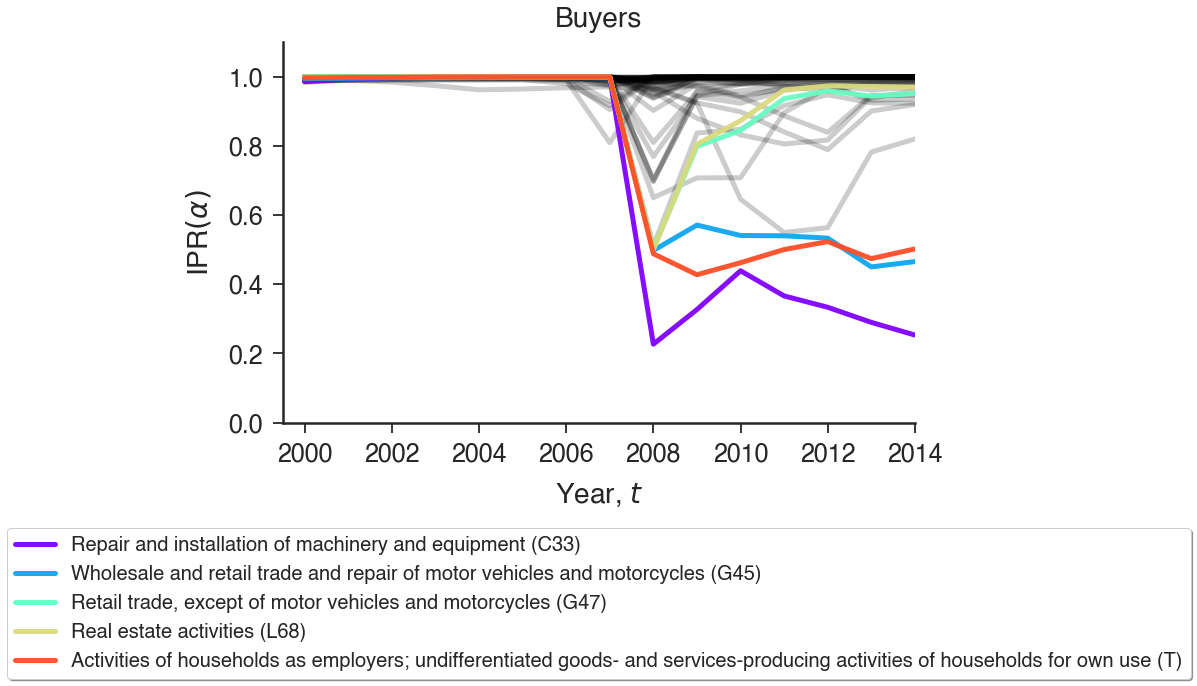

In [120]:
fig, ax = plt.subplots(figsize=(xs,ys))
colormap = plt.cm.rainbow
colors=[colormap(i) for i in np.linspace(0, 0.9,5)]
count=0
for i in range(0,56):
    if min(lipr[i])>0.51:
        ax.plot(x,lipr[i],marker='o',
                color='k',
                linewidth=5,
                markeredgecolor='k',
                markersize=0,
                alpha=0.2)
    else:
        count=count+1
        #print(i)
        ax.plot(x,lipr[i],marker='o',
                color=colors[count-1],
                linewidth=5,
                markeredgecolor='k',
                markersize=0,
                alpha=0.95,
                label=sectors.loc[i].Activity+' ('+sectors.loc[i].Code+')',zorder=10)
        
#ax.axvline(x=2008,color='#bdbdbd',linestyle='-',linewidth=30,zorder=-10)
ax.set_title('Buyers')

ax.set_xlim(1999.5,2014)
ax.set_ylim(0,1.1)
ax.set_ylabel(r"IPR${(\alpha)}$")
ax.set_xlabel(r"Year, $t$")
custom_frame(ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, fontsize=20,ncol=1,frameon=True)
plt.savefig("../figures/layer-ipr-buyers.pdf",bbox_inches='tight')

# Coutries that most contributed by sector

In [121]:
def country_rank(df,sel_sector,year):
    df_rank=df[df.Sector==sel_sector].sort_values(by='Total',ascending=False)
    df_rank.reset_index(drop=True,inplace=True)
    df_rank.reset_index(inplace=True)
    df_rank.rename(columns={'index':year},inplace=True)
    df_rank=df_rank[['Country',year]]
    return df_rank

def sector_rank(df,sel_country,year):
    df_rank=df[df.Country==sel_country].sort_values(by='Total',ascending=False)
    df_rank.reset_index(drop=True,inplace=True)
    df_rank.reset_index(inplace=True)
    df_rank.rename(columns={'index':year},inplace=True)
    df_rank=df_rank[['Sector',year]]
    return df_rank

In [122]:
def ec_supra_matrix(M,node_labels,n_layers,n_nodes,max_iter=50):
    """
    Calculates the eingenvector centrality for a multilayer network. 

    
    De Domenico, M. et al. Ranking in interconnected multilayer
    networks reveals versatile nodes. Nat. Commun. 6:6868 doi: 10.1038/ncomms7868
    (2015).
    
    input: 
        - M is an numpy array with the supra matrix of the multilayer network.
        - n_layers is the number of layers
        - n_nodes is the number of nodes in each layer
    output: 
        - centralitymnet 
    
    """
    import scipy as sp
    from scipy.sparse import linalg 

    eigenvalue, eigenvector = linalg.eigs(M.T, k=1, which='LR' ,maxiter=max_iter )
    largest = eigenvector.flatten().real
    norm = sp.sign(largest.sum())*sp.linalg.norm(largest)
    centrality = largest/norm

    return centrality

In [123]:
def calculate_ranks_sectors(m_list,countries,sectors,sel_country):
    index=[]
    for sector in sectors.Code.values:
        for country in countries.Country.values:
            index.append((country,sector))
    index=[np.transpose(index)[0],np.transpose(index)[1]]      


    buyers=pd.DataFrame(list(sectors.Code),columns=['Sector'])
    sellers=pd.DataFrame(list(sectors.Code),columns=['Sector'])
    
    for year in range(2000,2015):
        c=ec_supra_matrix(m_list[year-2000],node_labels=list(countries.Country),
                                 n_layers=56 ,n_nodes=43,max_iter=1000000)
        buyers_df=pd.DataFrame(c,index=index,columns=['Buyers'])
        buyers_df=buyers_df.reset_index()
        buyers_df=buyers_df.rename(columns={'level_0':'Country',
                                                  'level_1':'Sector',
                                                  'Buyers':'Total'})
        
        rank_buyers=sector_rank(buyers_df,sel_country,year)
        buyers=pd.merge(rank_buyers,buyers)
        
        c=ec_supra_matrix(m_list[year-2000].T,node_labels=list(countries.Country),
                                 n_layers=56 ,n_nodes=43,max_iter=1000000)
        sellers_df=pd.DataFrame(c,index=index,columns=['Sellers'])
        sellers_df=sellers_df.reset_index()
        sellers_df=sellers_df.rename(columns={'level_0':'Country',
                                                  'level_1':'Sector',
                                                  'Sellers':'Total'})
        
        rank_sellers=sector_rank(sellers_df,sel_country,year)
        sellers=pd.merge(rank_sellers,sellers)

        
    sellers=sellers.set_index('Sector').T
    sellers=sellers.sort_index()

    buyers=buyers.set_index('Sector').T
    buyers=buyers.sort_index()
    return buyers,sellers

In [124]:
buyers,sellers=calculate_ranks_sectors(m_list,countries,sectors,'United States')
buyers.head()

Sector  C29  O84  F  C26  J61  C28  C30  Q  C20  L68  ...  M74$\_$M75  H51  \
2000     13    0  7   11   14   22   40  2   20    1  ...          48   38   
2001     11    0  5   13   10   24   36  2   22    1  ...          48   39   
2002     10    1  6   15   11   26   36  2   19    0  ...          48   41   
2003     13    1  7   17   14   27   37  2   20    0  ...          48   40   
2004     14    2  5   20   15   27   36  1   19    0  ...          49   40   

Sector  H53  C33  H50   T  A02  A03  E36   U  
2000     45   50   49  52   51   54   53  55  
2001     45   50   49  52   51   54   53  55  
2002     45   50   49  52   51   54   53  55  
2003     43   50   47  52   51   54   53  55  
2004     43   50   47  52   51   53   54  55  

[5 rows x 56 columns]

In [125]:
def calculate_ranks(m_list,countries,sectors,sel_sector):
    index=[]
    for sector in sectors.Code.values:
        for country in countries.Country.values:
            index.append((country,sector))
    index=[np.transpose(index)[0],np.transpose(index)[1]]      


    buyers=pd.DataFrame(countries.Country,columns=['Country'])
    sellers=pd.DataFrame(countries.Country,columns=['Country'])
    
    for year in range(2000,2015):
        
        c=ec_supra_matrix(m_list[year-2000],node_labels=list(countries.Country),
                                 n_layers=56 ,n_nodes=43,max_iter=1000000)
        buyers_df=pd.DataFrame(c,index=index,columns=['Buyers'])
        buyers_df=buyers_df.reset_index()
        buyers_df=buyers_df.rename(columns={'level_0':'Country',
                                                  'level_1':'Sector',
                                                  'Buyers':'Total'})
        
        rank_buyers=country_rank(buyers_df,sel_sector,year)
        buyers=pd.merge(rank_buyers,buyers)
        
        c=ec_supra_matrix(m_list[year-2000].T,node_labels=list(countries.Country),
                                 n_layers=56 ,n_nodes=43,max_iter=1000000)
        sellers_df=pd.DataFrame(c,index=index,columns=['Sellers'])
        sellers_df=sellers_df.reset_index()
        sellers_df=sellers_df.rename(columns={'level_0':'Country',
                                                  'level_1':'Sector',
                                                  'Sellers':'Total'})
        
        rank_sellers=country_rank(sellers_df,sel_sector,year)
        sellers=pd.merge(rank_sellers,sellers)      
        
    sellers=sellers.set_index('Country').T
    sellers=sellers.sort_index()

    buyers=buyers.set_index('Country').T
    buyers=buyers.sort_index()
    return buyers,sellers

In [126]:
buyers,sellers=calculate_ranks(m_list,countries,sectors,'C33')

In [127]:
def plot_ranks(r_var,data_df,colors):
    count=0
    for i,country in enumerate(r_var):
        if i<3:
            ax.plot(data_df.index,data_df[country].values+1,color=colors[count],alpha=1,label=country)
            print('Increase:',country,sector)
            count=count+1
        elif i>39:
            ax.plot(data_df.index,data_df[country].values+1,color=colors[count],alpha=1,label=country)
            count=count+1
            print('Decrease:',country,sector)
        else:
            ax.plot(data_df.index,data_df[country].values+1,color='gray',alpha=0.3,linewidth=2)
    return ax

def plot_ranks_sectors(r_var,data_df,colors):
    count=0
    for i,sector in enumerate(r_var):
        if i<3:
            ax.plot(data_df.index,data_df[sector].values+1,color=colors[count],alpha=1,label=sector)
            print('Increase:',country,sector)
            count=count+1
        elif i>52:
            ax.plot(data_df.index,data_df[sector].values+1,color=colors[count],alpha=1,label=sector)
            count=count+1
            print('Decrease:',country,sector)
        else:
            ax.plot(data_df.index,data_df[sector].values+1,color='gray',alpha=0.3,linewidth=2)
    return ax

In [128]:
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

In [129]:
colors=['#e41a1c',
        '#377eb8',
        '#4daf4a',
        '#984ea3',
        '#ff7f00',
        '#ffff33']



Increase: Russian Federation G45
Increase: Taiwan G45
Increase: Denmark G45
Decrease: Austria G45
Decrease: Greece G45
Decrease: Ireland G45
Increase: Poland G45
Increase: Australia G45
Increase: Belgium G45
Decrease: Switzerland G45
Decrease: Ireland G45
Decrease: Mexico G45


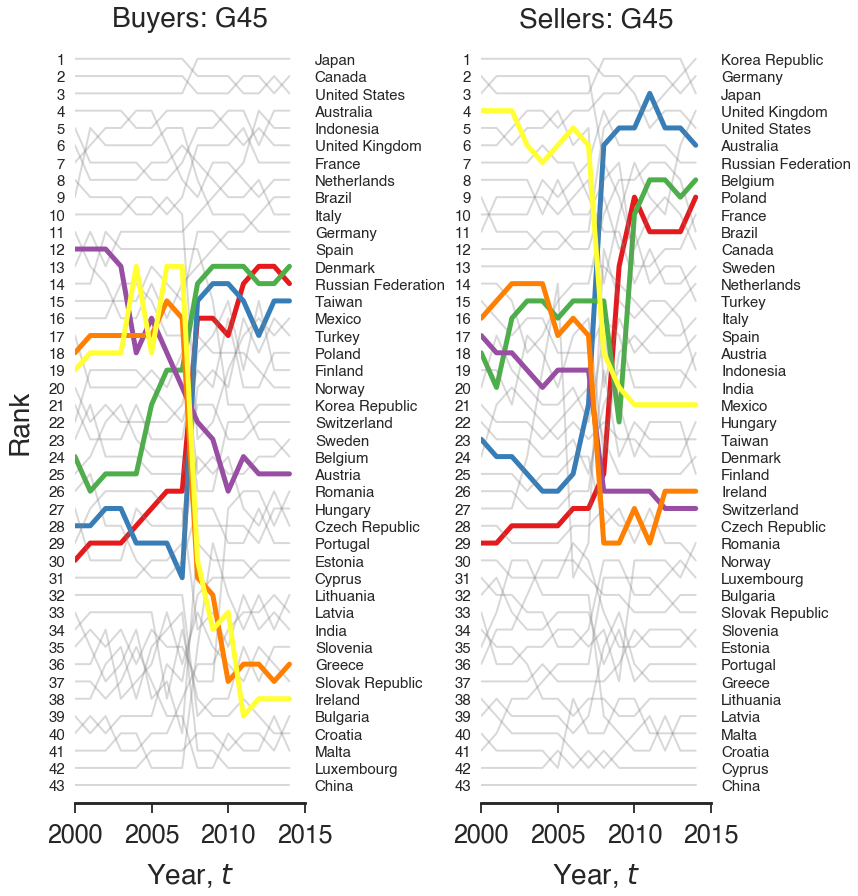

Increase: Canada C33
Increase: Czech Republic C33
Increase: Poland C33
Decrease: Mexico C33
Decrease: Sweden C33
Decrease: Ireland C33
Increase: Austria C33
Increase: Australia C33
Increase: Romania C33
Decrease: United Kingdom C33
Decrease: Malta C33
Decrease: Mexico C33


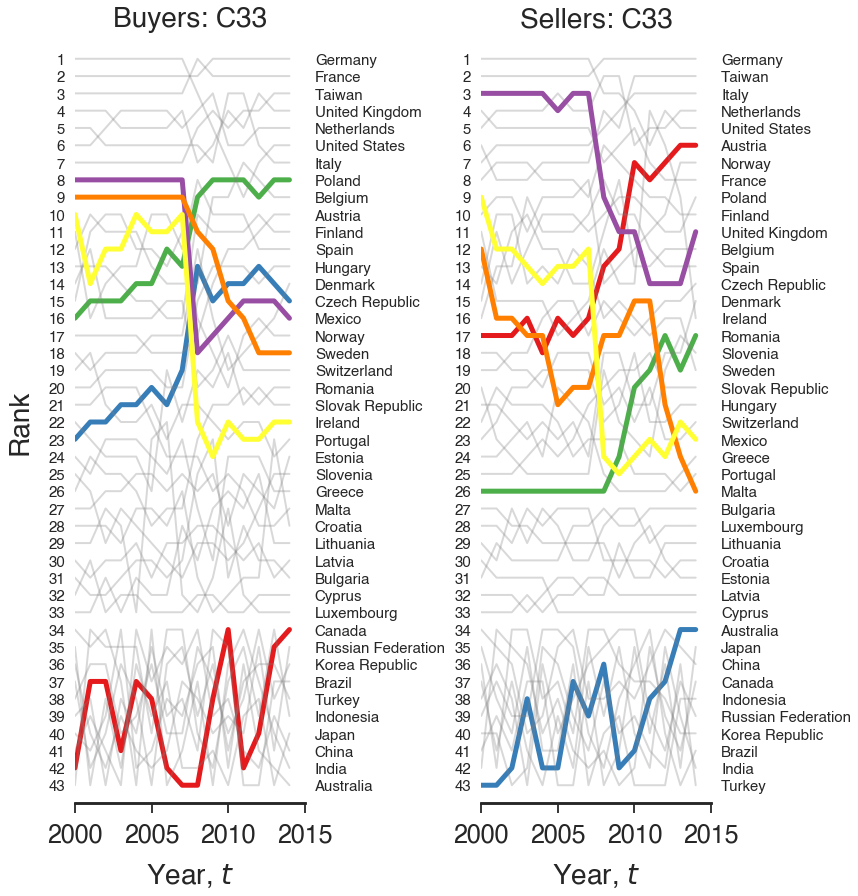

In [130]:
for sector in ['G45','C33']:
    buyers,sellers=calculate_ranks(m_list,countries,sectors,sel_sector=sector)
    
    fig = plt.figure(figsize=(xs*.8,ys*2))
    ax = fig.add_subplot(1,2,1)
    
    rvar=((buyers.T[2014])-(buyers.T[2000])).sort_values(ascending=True).index
    ax=plot_ranks(rvar,buyers,colors)

    ax.set_xlim(2000,2015)
    ax.set_ylim(44,0)
    ax.set_yticks(np.arange(1, 44, 1.0))
    ax.set_yticklabels([int(i) for i in range(1, 44, 1)],fontsize=15)
    ax.set_title('Buyers: {}'.format(sector))
    ax.set_ylabel(r"Rank")
    ax.set_xlabel(r"Year, $t$")
    custom_frame(ax)
    ax.tick_params(axis='y',direction='out',length=0)
    axr = ax.twinx()
    axr.set_ylim(0,44)
    axr.set_yticks(np.arange(1, 44, 1))
    axr.tick_params(axis='y',direction='out',length=0)
    axr.set_yticklabels(buyers.T.sort_values(by=2014).index[::-1],fontsize=15)


    ax = fig.add_subplot(1,2,2)
    bbox=plt.gca().get_position()
    offset=-0.2
    plt.gca().set_position([bbox.x0-offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

    rvar=((sellers.T[2014])-(sellers.T[2000])).sort_values(ascending=True).index
    ax=plot_ranks(rvar,sellers,colors)

    ax.set_xlim(2000,2015)
    ax.set_ylim(44,0)
    ax.set_yticks(np.arange(1, 44, 1.0))
    ax.set_yticklabels([int(i) for i in range(1, 44, 1)],fontsize=15)
    ax.set_title('Sellers: {}'.format(sector))
    ax.set_xlabel(r"Year, $t$")
    custom_frame(ax)
    ax.tick_params(axis='y',direction='out',length=0)

    axr = ax.twinx()
    bbox=plt.gca().get_position()
    offset=-0.2
    plt.gca().set_position([bbox.x0-offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

    axr.set_ylim(0,44)
    axr.set_yticks(np.arange(1, 44, 1))
    axr.tick_params(axis='y',direction='out',length=0)
    axr.set_yticklabels(sellers.T.sort_values(by=2014).index[::-1],fontsize=15)
    plt.savefig("../figures/{}.pdf".format(sector),bbox_inches='tight')
    plt.show()

Increase: United States C30
Increase: United States C27
Increase: United States C28
Decrease: United States D35
Decrease: United States K64
Decrease: United States K65
Increase: United States H51
Increase: United States C31$\_$C32
Increase: United States A01
Decrease: United States R$\_$S
Decrease: United States J59$\_$J60
Decrease: United States K66


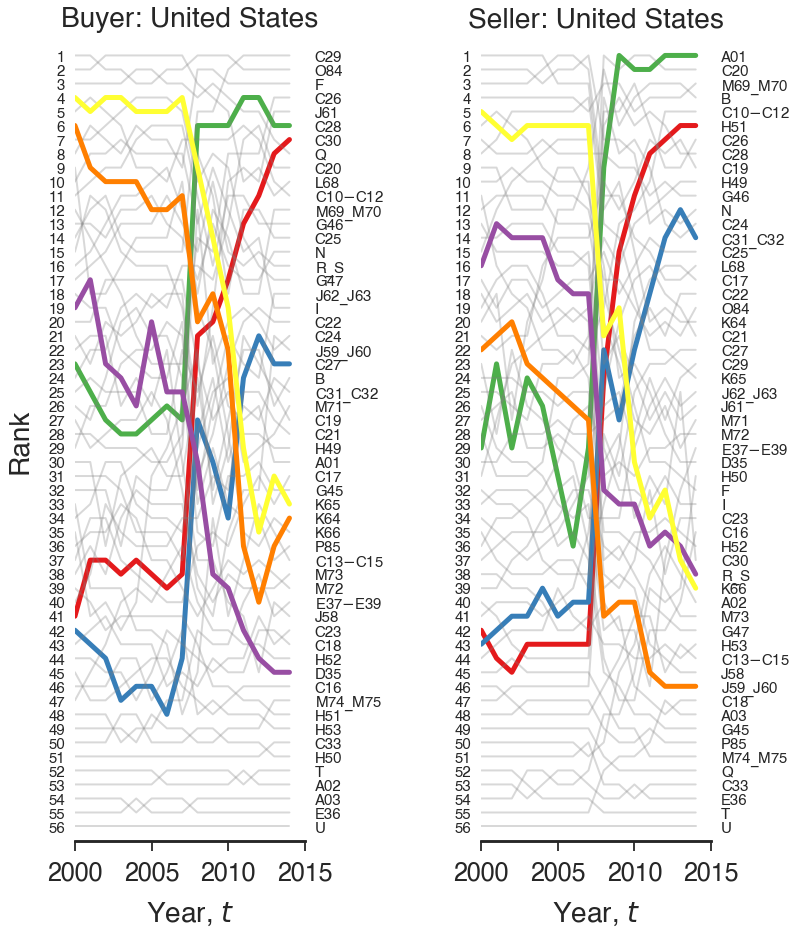

Increase: China C19
Increase: China M74$\_$M75
Increase: China C29
Decrease: China A01
Decrease: China H50
Decrease: China G46
Increase: China A01
Increase: China H52
Increase: China M74$\_$M75
Decrease: China C17
Decrease: China C31$\_$C32
Decrease: China H51


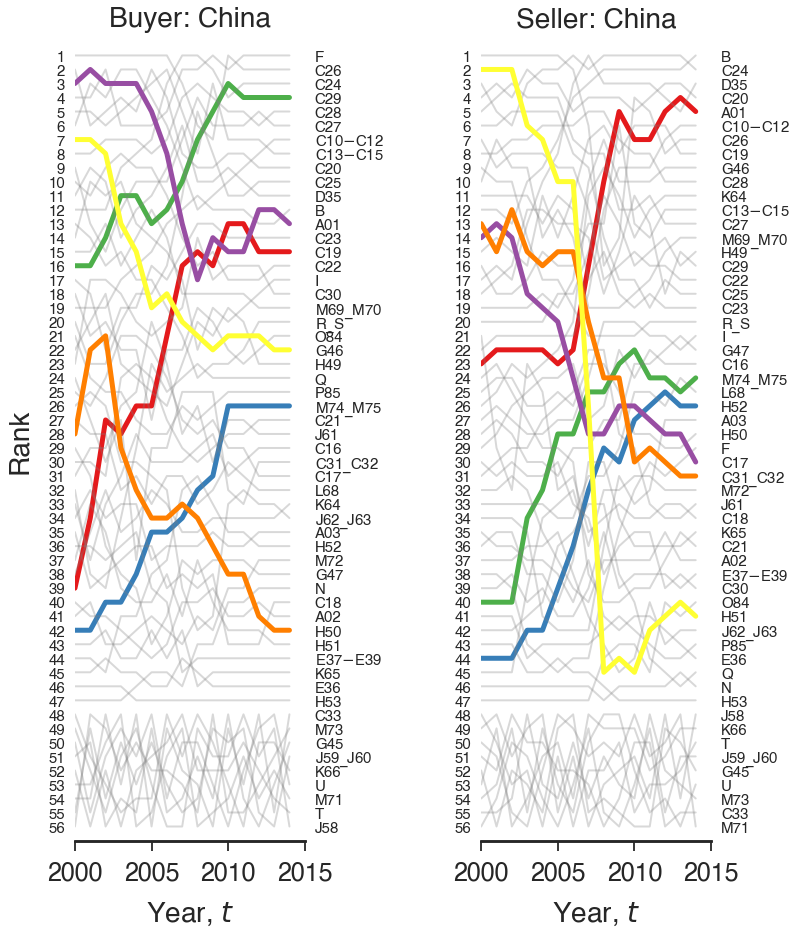

In [131]:
for country in ['United States','China']:
# for sectort in list(sectors.Code):
    buyers,sellers=calculate_ranks_sectors(m_list,countries,sectors,sel_country=country)
    
    fig = plt.figure(figsize=(xs*.8,ys*2.1))
    ax = fig.add_subplot(1,2,1)
    
    rvar=((buyers.T[2014])-(buyers.T[2000])).sort_values(ascending=True).index
    ax=plot_ranks_sectors(rvar,buyers,colors)

    ax.set_xlim(2000,2015)
    ax.set_ylim(57,0)
    ax.set_yticks(np.arange(1, 57, 1.0))
    ax.set_yticklabels([int(i) for i in range(1, 57, 1)],fontsize=15)
    ax.set_title('Buyer: {}'.format(country))
    ax.set_ylabel(r"Rank")
    ax.set_xlabel(r"Year, $t$")
    custom_frame(ax)
    ax.tick_params(axis='y',direction='out',length=0)
    axr = ax.twinx()
    axr.set_ylim(0,57)
    axr.set_yticks(np.arange(1, 57, 1))
    axr.tick_params(axis='y',direction='out',length=0)
    axr.set_yticklabels(buyers.T.sort_values(by=2014).index[::-1],fontsize=15)


    ax = fig.add_subplot(1,2,2)
    bbox=plt.gca().get_position()
    offset=-0.2
    plt.gca().set_position([bbox.x0-offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

    rvar=((sellers.T[2014])-(sellers.T[2000])).sort_values(ascending=True).index
    ax=plot_ranks_sectors(rvar,sellers,colors)

    ax.set_xlim(2000,2015)
    ax.set_ylim(57,0)
    ax.set_yticks(np.arange(1, 57, 1.0))
    ax.set_yticklabels([int(i) for i in range(1, 57, 1)],fontsize=15)
    ax.set_title('Seller: {}'.format(country))
    ax.set_xlabel(r"Year, $t$")
    custom_frame(ax)
    ax.tick_params(axis='y',direction='out',length=0)

    axr = ax.twinx()
    bbox=plt.gca().get_position()
    offset=-0.2
    plt.gca().set_position([bbox.x0-offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

    axr.set_ylim(0,57)
    axr.set_yticks(np.arange(1, 57, 1))
    axr.tick_params(axis='y',direction='out',length=0)
    axr.set_yticklabels(sellers.T.sort_values(by=2014).index[::-1],fontsize=15)
    plt.savefig("../figures/rank_sectors_{}.pdf".format(country),bbox_inches='tight')
    plt.show()

In [132]:
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

# The role of domestic trade

In [133]:
from functions import *

In [134]:
import time

In [135]:
def nodomesticonsumption_edges(year=2010):
    data_path="../data/{}/multilayer/edges-{}.csv".format(year,year)
    edge_df=pd.read_csv(data_path)[['source_node', 'source_layer', 'destination_node','destination_layer', 'weight']]
    domestic_consumption=edge_df[edge_df.source_node!=edge_df.destination_node].index
    edge_df.at[domestic_consumption,'weight']=0
    return edge_df

def nodomesticconsumption_supra_matrix(year=2010):
    def fxn():
        warnings.warn("deprecated", DeprecationWarning)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        edge_df=nodomesticonsumption_edges(year=year)
        number_of_countries=43
        number_of_layers=56
        m=np.zeros((number_of_layers*number_of_countries,number_of_layers*number_of_countries))
        for alpha in range(1,number_of_layers+1,1):
            for beta in range(1,number_of_layers+1,1):
                edges=edge_df[edge_df.source_layer==alpha][edge_df.destination_layer==beta][["source_node","destination_node",'weight']]
                edges=np.array(edges)
                for edge in edges:
                    m[number_of_countries*(alpha-1):number_of_countries*alpha,
                      number_of_countries*(beta-1):number_of_countries*beta][int(edge[0]-1)][int(edge[1]-1)]=edge[2]
    return m

nodomesticcomsumptionm_list=[]
start=time.time()
for year in range(2000,2015):
    m=nodomesticconsumption_supra_matrix(year=year)
    nodomesticcomsumptionm_list.append(m)
    print(year,time.time()-start)

2000 25.221408128738403
2001 50.35395908355713
2002 75.49813508987427
2003 100.57910418510437
2004 125.75870108604431
2005 151.15873527526855
2006 176.24115800857544
2007 201.3457350730896
2008 226.3703911304474
2009 251.5644690990448
2010 276.9571430683136
2011 302.3437912464142
2012 327.78177309036255
2013 353.16477704048157
2014 378.67383098602295


[]

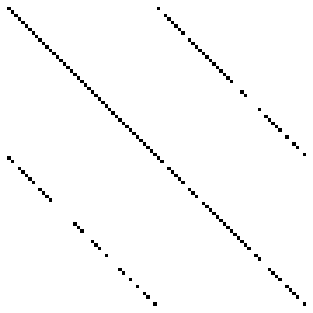

In [136]:
fig, ax = plt.subplots(figsize=(7,5.5))
ax=sns.heatmap(binarize(nodomesticcomsumptionm_list[0][:86].T[:86].T,threshold=1),cmap='Greys',vmin=0,vmax=1,cbar=False,square=True)
ax.set_yticks([])
ax.set_xticks([])

[]

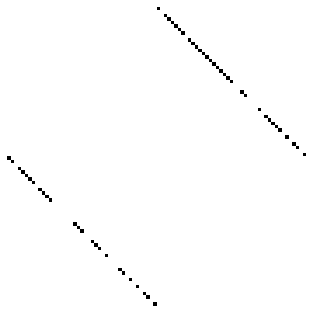

In [137]:
i=0
m=nodomesticcomsumptionm_list[i]
databinarized=binarize(m[:86].T[:86].T,threshold=1)
databinarized=databinarized-np.identity(len(databinarized))
fig, ax = plt.subplots(figsize=(7,5.5))
ax=sns.heatmap(databinarized,cmap='Greys',vmin=0,vmax=1,cbar=False,square=True)
ax.set_yticks([])
ax.set_xticks([])

## Varying domestic trade as a parameter

In [138]:
clist=np.logspace(-3,0,50)

In [139]:
sellers=[]
for k in range(0,15):
    c=0
    m=m_list[k].copy()
    shapeij=m.shape
    m0=nodomesticcomsumptionm_list[k]
    m0=m0.ravel()
    m=m.ravel()
    indices=np.where(m0>0)
    m0=m0*c
    np.put(m,indices,np.take(m0,indices))
    m=m.reshape(shapeij)

    centrality=mnet_eigen_centrality(m.T,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43)

    eig_df=pd.DataFrame(pd.Series(centrality,index=centrality.keys()),columns=[0])
    eig_df=eig_df.reset_index().rename(columns={'index':'Countries'})


    count=0
    for c in clist:
        count=count+1
        m=m_list[k].copy()
        shapeij=m.shape
        m0=nodomesticcomsumptionm_list[k]
        m0=m0.ravel()
        m=m.ravel()
        indices=np.where(m0>0)
        m0=m0*c
        np.put(m,indices,np.take(m0,indices))
        m=m.reshape(shapeij)

        centrality=mnet_eigen_centrality(m.T,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43)

        eig_df2=pd.DataFrame(pd.Series(centrality,index=centrality.keys()),columns=[count])
        eig_df2=eig_df2.reset_index().rename(columns={'index':'Countries'})
        eig_df=pd.merge(eig_df,eig_df2,on='Countries')
    y=np.transpose([np.sum(eig_df[c]**4)/np.sum(eig_df[c]**2)**2 for c in range(0,len(clist)+1)])
    sellers.append(y)

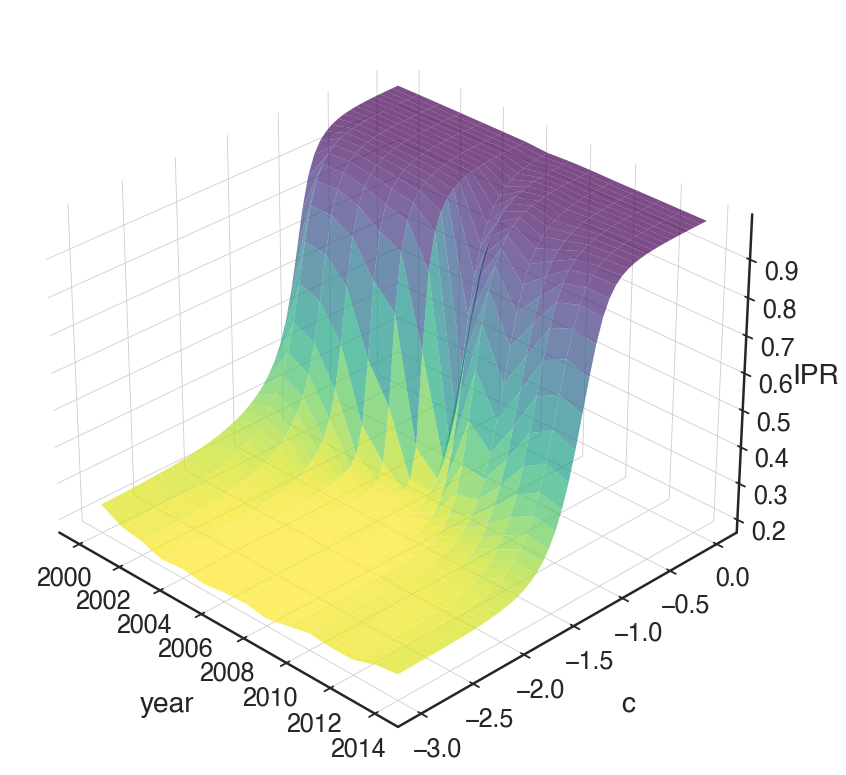

In [140]:
data_toplot=[]
for j in range(0,len(sellers)):
    data_toplot.append(np.transpose([np.append([0],clist),sellers[j],[2000+j for i in range(0,len(sellers[0]))]]))



from mpl_toolkits import mplot3d
c,ipr,year=np.transpose(data_toplot)
fig = plt.figure(figsize=(xs*2,ys*2))
ax = plt.axes(projection='3d')
data=ax.plot_surface( year,np.log10(c),ipr, rstride=1, cstride=1,
                cmap='viridis_r', edgecolor='none',alpha=0.7)

ax.set_xlabel('year', labelpad=40)
ax.set_ylabel('c', labelpad=40)
ax.set_zlabel('IPR', labelpad=20)
ax.tick_params(axis='z', which='major', pad=10)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
#ax.grid(False)

ax.view_init(30,-45)
plt.savefig("../figures/3dlocalization-transition-sellers.pdf",bbox_inches='tight')

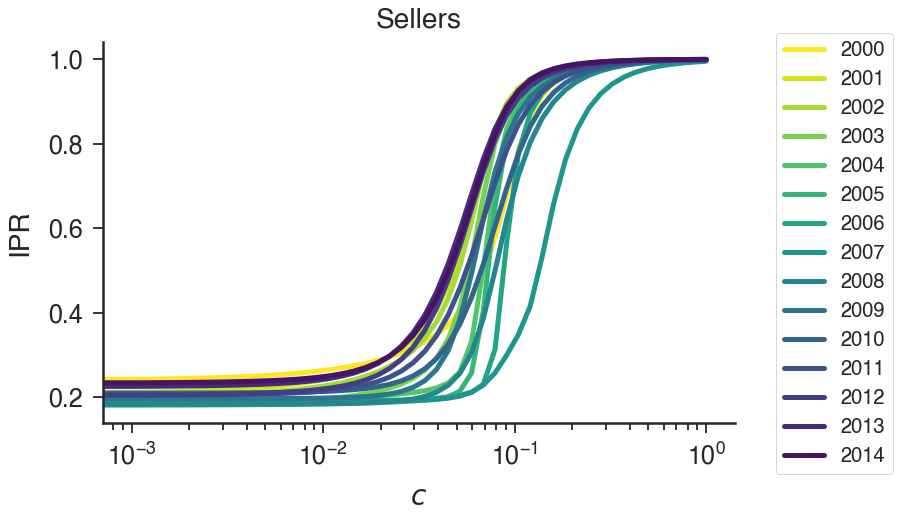

In [141]:
x=np.append([0],clist)
fig, ax = plt.subplots(figsize=(xs,ys))

colormap = plt.cm.viridis_r
colors=[colormap(i) for i in np.linspace(0, 0.95,15)]

for i,y in enumerate(sellers):
    ax.plot(x,y,marker='o',
            color=colors[i],
            markeredgecolor='k',
            markersize=0,
            linewidth=5,
           label=i+2000)
    
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20)
ax.set_ylabel(r"IPR")
ax.set_xlabel(r"$c$")
ax.set_title('Sellers')
custom_frame(ax)

plt.savefig("../figures/localization-transition-sellers.pdf",bbox_inches='tight')

In [142]:
len(y),len(np.diff(y))

(51, 50)

In [143]:
x[np.where(np.diff(y)==np.max(np.diff(y)))]

array([0.05963623])

0.0825109882623203


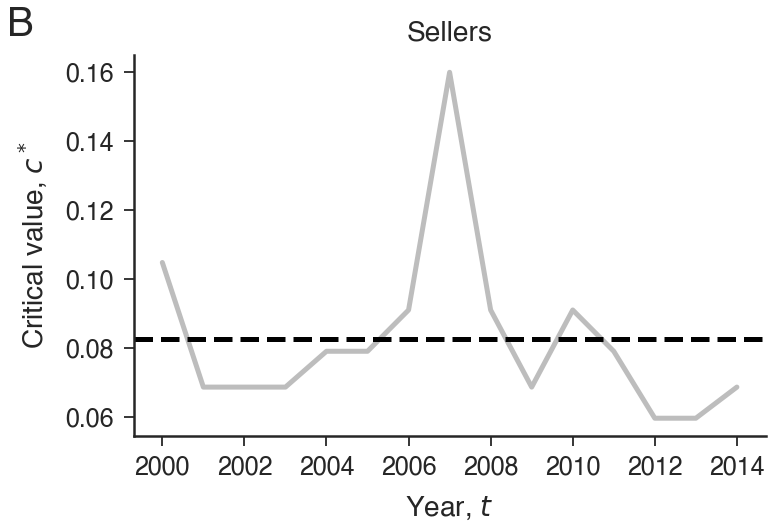

In [144]:
x=np.append([0],clist)

critical_value=[]
for i,y in enumerate(sellers):
    critical_value.append(x[np.where(np.diff(y)==np.max(np.diff(y)))[0][0]+1])

fig, ax = plt.subplots(figsize=(xs,ys))
ax.plot([year for year in range(2000,2015)],critical_value,'#bdbdbd')
ax.axhline(np.average(critical_value),color='k',linestyle='dashed')
print(np.average(critical_value))
ax.set_ylabel(r"Critical value, $c^*$")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Sellers')
custom_frame(ax)
plt.annotate('B', xy=(-0.2, 1.05), xycoords="axes fraction",fontsize=40,fontweight="bold")
plt.savefig("../figures/crtical_value_sellers.pdf",bbox_inches='tight')

In [145]:
buyers=[]
for k in range(0,15):
    c=0
    m=m_list[k].copy()
    shapeij=m.shape
    m0=nodomesticcomsumptionm_list[k]
    m0=m0.ravel()
    m=m.ravel()
    indices=np.where(m0>0)
    m0=m0*c
    np.put(m,indices,np.take(m0,indices))
    m=m.reshape(shapeij)
    centrality=mnet_eigen_centrality(m,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43)
    eig_df=pd.DataFrame(pd.Series(centrality,index=centrality.keys()),columns=[0])
    eig_df=eig_df.reset_index().rename(columns={'index':'Countries'})
    count=0
    for c in clist:
        count=count+1
        m=m_list[k].copy()
        shapeij=m.shape
        m0=nodomesticcomsumptionm_list[k]
        m0=m0.ravel()
        m=m.ravel()
        indices=np.where(m0>0)
        m0=m0*c
        np.put(m,indices,np.take(m0,indices))
        m=m.reshape(shapeij)
        centrality=mnet_eigen_centrality(m,node_labels=list(countries.Country),n_layers=56 ,n_nodes=43)
        eig_df2=pd.DataFrame(pd.Series(centrality,index=centrality.keys()),columns=[count])
        eig_df2=eig_df2.reset_index().rename(columns={'index':'Countries'})
        eig_df=pd.merge(eig_df,eig_df2,on='Countries')
    y=np.transpose([np.sum(eig_df[c]**4)/np.sum(eig_df[c]**2)**2 for c in range(0,len(clist)+1)])
    buyers.append(y)

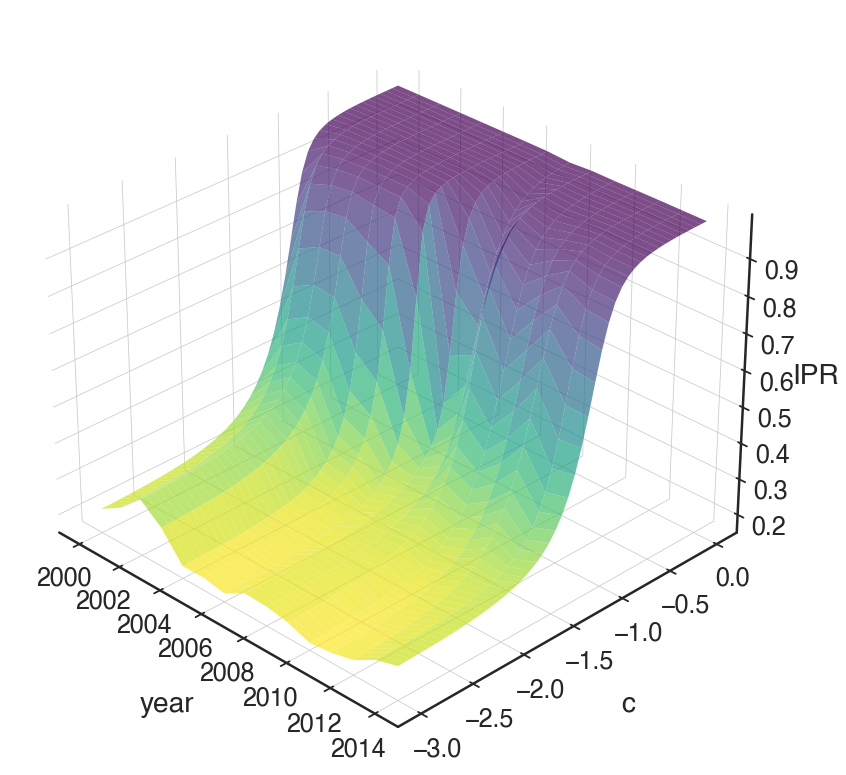

In [146]:
data_toplot=[]
for j in range(0,len(buyers)):
    data_toplot.append(np.transpose([np.append([0],clist),buyers[j],[2000+j for i in range(0,len(buyers[0]))]]))



from mpl_toolkits import mplot3d
c,ipr,year=np.transpose(data_toplot)
fig = plt.figure(figsize=(xs*2,ys*2))
ax = plt.axes(projection='3d')
data=ax.plot_surface( year,np.log10(c),ipr, rstride=1, cstride=1,
                cmap='viridis_r', edgecolor='none',alpha=0.7)

ax.set_xlabel('year', labelpad=40)
ax.set_ylabel('c', labelpad=40)
ax.set_zlabel('IPR', labelpad=20)
ax.tick_params(axis='z', which='major', pad=10)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
#ax.grid(False)

ax.view_init(30,-45)
plt.savefig("../figures/3dlocalization-transition-buyers.pdf",bbox_inches='tight')

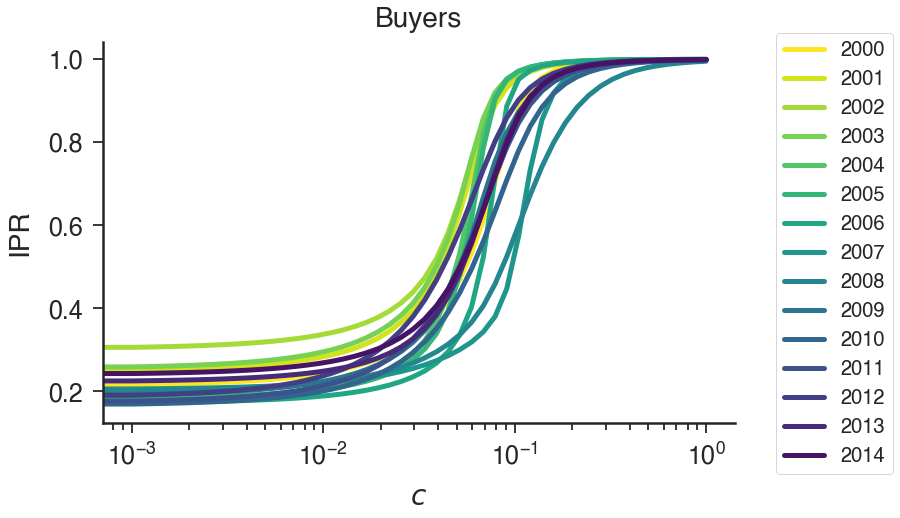

In [147]:
x=np.append([0],clist)
fig, ax = plt.subplots(figsize=(xs,ys))
colormap = plt.cm.viridis_r
colors=[colormap(i) for i in np.linspace(0, 0.95,15)]
for i,y in enumerate(buyers):
    ax.plot(x,y,marker='o',
            color=colors[i],
            markeredgecolor='k',
            markersize=0,
            linewidth=5,
           label=i+2000)

ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.05,1.05), loc="upper left",fontsize=20)
ax.set_ylabel(r"IPR")
ax.set_xlabel(r"$c$")
ax.set_title('Buyers')
custom_frame(ax)
plt.savefig("../figures/localization-transition-buyers.pdf",bbox_inches='tight')

0.07954854197746915


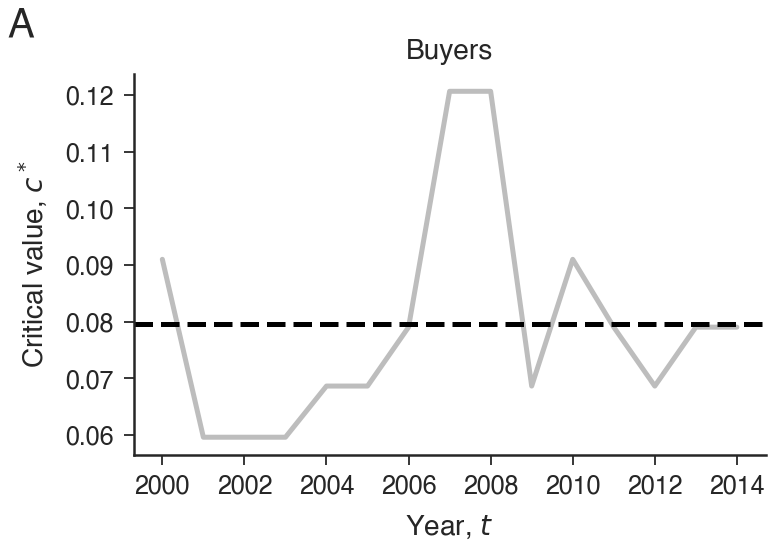

In [148]:
x=np.append([0],clist)

critical_value=[]
for i,y in enumerate(buyers):
    critical_value.append(x[np.where(np.diff(y)==np.max(np.diff(y)))[0][0]+1])

fig, ax = plt.subplots(figsize=(xs,ys))
ax.plot([year for year in range(2000,2015)],critical_value,'#bdbdbd')
ax.axhline(np.average(critical_value),color='k',linestyle='dashed')
print(np.average(critical_value))
ax.set_ylabel(r"Critical value, $c^*$")
ax.set_xlabel(r"Year, $t$")
ax.set_title('Buyers')
custom_frame(ax)
plt.annotate('A', xy=(-0.2, 1.1), xycoords="axes fraction",fontsize=40,fontweight="bold")
plt.savefig("../figures/critical_value_buyers.pdf",bbox_inches='tight')

In [149]:
import watermark
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 02 2022

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.18.1

seaborn   : 0.11.2
graph_tool: 2.43 (commit , )
watermark : 2.3.0
sys       : 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:50:38) 
[Clang 11.1.0 ]
pandas    : 1.3.4
cartopy   : 0.20.2
scipy     : 1.7.3
palettable: 3.3.0
networkx  : 2.4
numpy     : 1.21.4
matplotlib: 3.4.3

Watermark: 2.3.0

